# 05-predicting-IBS-vs-HC-from-morphometric-measures.ipynb

Using `ibs-brain` conda environment

Arvid Lundervold

Last updated: 2024-12-18

This notebook explores the use of morphometric measures to predict IBS vs HC.<br>
It also performs **imputation of 6 missing values of IBS_SSS** using the median of those remaining subjects that have the same Group and Gender, saving the file `demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv`

We are using the low-code machine learning tool PyCaret (https://pycaret.org) for the prediction **x**$_i \mapsto y_i$; $i=1,\ldots,n=78$ in the analysis $y \approx f(X,\theta)$ of the BGA data. 

**X** is based on recon-all longitudinal stream (**ASEG morphometry**) (using BGA ids, cfr. first part of al-10-freesurfer-analysis.iynb) and **RBANS**-derived viariables<br>


See also our "_Decoding IBS: A Machine Learning Approach to Psychological Distress and Gut-Brain Interaction_": [**IBS-distress**](https://github.com/arvidl/ibs-distress) project on GitHub and its [**notebooks**](https://github.com/arvidl/ibs-distress/tree/main/notebooks)




In [1]:
import os
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pycaret
import ydata_profiling
from ydata_profiling import ProfileReport
import platform
import shutil
import warnings
import datetime
import pingouin as pg
import xgboost as xgb
from pycaret.classification import *
from pycaret.regression import *
from pycaret.clustering import *
from pycaret.anomaly import *
from sklearn.gaussian_process import GaussianProcessClassifier as gpc
from sklearn.gaussian_process.kernels import RBF

# import MLP from scikit-learn  
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import scikitplot as skplt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import mutual_info_regression

from sklearn.preprocessing import StandardScaler

import shap

home = os.path.expanduser('~')

%matplotlib inline

In [2]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10/11 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install')

OK, you are running on MacOS (Darwin Kernel Version 24.2.0: Fri Dec  6 18:41:43 PST 2024; root:xnu-11215.61.5~2/RELEASE_X86_64)


In [3]:
# Versions

print(f'seaborn: {sns.__version__}')
print(f'pandas: {pd.__version__}')
print(f'pycaret: {pycaret.__version__}')
print(f'ydata_profiling: {ydata_profiling.__version__}')
print(f'pingouin: {pg.__version__}')
print(f'xgboost: {xgb.__version__}')
print(f'scikit-learn: {sklearn.__version__}')
print(f'shap: {shap.__version__}')
print(f'scikit-plot: {skplt.__version__}')

seaborn: 0.13.2
pandas: 2.1.4
pycaret: 3.3.2
ydata_profiling: v4.12.0
pingouin: 0.5.5
xgboost: 2.1.2
scikit-learn: 1.4.2
shap: 0.46.0
scikit-plot: 0.3.7


#### Read data with information about demographics, brain morphometry and RBANS for 78 participants

In [4]:
df = pd.read_csv('../data/demographics_fs7_rbans_78x48.csv')
df

,Subject,Group,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,...,Fullscale_RBANS,Memory_Index,Visuospatial_Index,Verbalskills_Index,Attention_Index,Recall_Index,IBS_SSS,Age,Gender,Education
0,BGA_046,IBS,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,0.003099,...,100,80,102,93,97,86,195.0,38,M,12.0
1,BGA_047,IBS,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,0.002999,...,116,109,107,97,115,126,325.0,19,F,13.0
2,BGA_048,IBS,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,0.003533,...,95,83,84,113,103,100,326.0,34,F,13.0
3,BGA_050,IBS,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,...,87,86,97,90,98,86,357.0,44,F,18.0
4,BGA_051,IBS,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,0.002864,...,100,105,90,97,108,100,293.0,38,M,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,0.002845,...,93,89,90,118,108,82,56.0,19,F,NaN
74,BGA_167,HC,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,0.002759,...,97,83,85,116,113,23,25.0,52,F,NaN
75,BGA_168,HC,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,0.003182,...,100,100,103,107,86,104,21.0,50,F,NaN
76,BGA_171,HC,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,0.002967,...,96,89,102,85,101,110,32.0,21,M,NaN


In [5]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
eTIV,78.0,1.474885e+06,153928.840484,1.215809e+06,1.377170e+06,1.448416e+06,1.560284e+06,1.888063e+06
Left-Cerebellum-White-Matter,78.0,1.076200e-02,0.001054,8.647242e-03,1.015243e-02,1.077838e-02,1.129687e-02,1.365434e-02
Left-Cerebellum-Cortex,78.0,3.730862e-02,0.003574,3.008196e-02,3.470547e-02,3.724610e-02,3.979467e-02,4.747275e-02
Left-Thalamus,78.0,5.307679e-03,0.000490,4.015864e-03,4.947000e-03,5.369929e-03,5.647868e-03,6.334723e-03
Left-Caudate,78.0,2.485910e-03,0.000313,1.813820e-03,2.222271e-03,2.491968e-03,2.672869e-03,3.169705e-03
Left-Putamen,78.0,3.650897e-03,0.000387,2.812394e-03,3.358667e-03,3.626083e-03,3.880776e-03,4.655418e-03
Left-Pallidum,78.0,1.388744e-03,0.000123,1.033969e-03,1.317441e-03,1.384625e-03,1.475025e-03,1.723574e-03
Left-Hippocampus,78.0,2.941966e-03,0.000254,2.341288e-03,2.766887e-03,2.954976e-03,3.097828e-03,3.533187e-03
Left-Amygdala,78.0,1.221333e-03,0.000123,9.564543e-04,1.125478e-03,1.225040e-03,1.314175e-03,1.591444e-03
Left-Accumbens-area,78.0,4.330288e-04,0.000071,2.726292e-04,3.850259e-04,4.373269e-04,4.863204e-04,5.769951e-04


In [6]:
print('Age distribution:')
df.groupby(['Gender', 'Group']).Age.describe().round(3)

Age distribution:


count    mean     std   min   25%   50%    75%   max
Gender Group                                                      
F      HC      20.0  36.900  13.630  19.0  23.0  37.5  49.25  58.0
       IBS     38.0  34.947  11.109  19.0  26.5  33.0  41.75  61.0
M      HC       9.0  31.444  12.177  21.0  22.0  26.0  38.00  58.0
       IBS     11.0  37.364   6.932  28.0  32.0  38.0  42.50  48.0

In [7]:
# Make a cross tabulation of Gender and Group with marginals
pd.crosstab(df['Gender'], df['Group'], margins=True)

Group,HC,IBS,All
Gender,,,
F,20,38,58
M,9,11,20
All,29,49,78


In [8]:
# Combinatorial selection of feature values (Example)
df_M_IBS = df[(df['Age'] > 0.0) & ~(df['Gender'] == 'F') & (df['Group'] == 'IBS')]
imp_mean = df_M_IBS.Age.values.mean().round(1)
print('df_M_IBS.Age:', list(df_M_IBS.Age), '-> Mean age:', imp_mean)

df_M_IBS.Age: [38, 38, 31, 42, 28, 30, 33, 47, 48, 43, 33] -> Mean age: 37.4


#### A possible simplification of the data by summing the left and right hemisphere values for each brain region
```python
df_X['Thalamus'] = df_X['Left-Thalamus'] + df_X['Right-Thalamus']
df_X['Caudate'] = df_X['Left-Caudate'] + df_X['Right-Caudate'] 
df_X['Putamen'] = df_X['Left-Putamen'] + df_X['Right-Putamen'] 
df_X['Pallidum'] = df_X['Left-Pallidum'] + df_X['Right-Pallidum'] 
df_X['Hippocampus'] = df_X['Left-Hippocampus'] + df_X['Right-Hippocampus'] 
df_X['Amygdala'] = df_X['Left-Amygdala'] + df_X['Right-Amygdala'] 
df_X['Accumbens-area'] = df_X['Left-Accumbens-area'] + df_X['Right-Accumbens-area']
```

In [9]:
## Select features (as reported in Skrobisz et al. 2022)

variables = df.columns

exclude_cols_1 = ['Subject', 'Group', 'IBS_SSS', 'Age', 'Gender', 'Education', 'Fullscale_RBANS', 'Memory_Index',
       'Visuospatial_Index', 'Verbalskills_Index', 'Attention_Index',
       'Recall_Index']

sel_cols_1 = [col for col in variables if col not in exclude_cols_1]

df_X1 = df[sel_cols_1]

df_X1['Outcome'] = df['Group']

df_X1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 37 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   eTIV                           78 non-null     float64
 1   Left-Cerebellum-White-Matter   78 non-null     float64
 2   Left-Cerebellum-Cortex         78 non-null     float64
 3   Left-Thalamus                  78 non-null     float64
 4   Left-Caudate                   78 non-null     float64
 5   Left-Putamen                   78 non-null     float64
 6   Left-Pallidum                  78 non-null     float64
 7   Left-Hippocampus               78 non-null     float64
 8   Left-Amygdala                  78 non-null     float64
 9   Left-Accumbens-area            78 non-null     float64
 10  CSF                            78 non-null     float64
 11  Right-Cerebellum-White-Matter  78 non-null     float64
 12  Right-Cerebellum-Cortex        78 non-null     float

# Using PyCaret  

#### Introducing the data frame df1 with predictors $X$ and outcome $y$

Seen as a **classification problem** with the following settings:

**Predictors (X):** ['eTIV', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex', 'Left-Thalamus',...,'SubCortGrayVol', 'TotalGrayVol'], i.e. all that are reported in Skrobisz et al. 2022<br>
**Target (y):** Outcome (HC, IBS)

In [10]:
df_X1.columns

Index(['eTIV', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'CSF',
       'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex',
       'Right-Thalamus', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum',
       'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area',
       'WM-hypointensities', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central',
       'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent',
       'lhCortexVol', 'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol', 'Outcome'],
      dtype='object')

In [11]:
df1 = df_X1.copy()

# Recode the 'Outcome' values
df1['Outcome'] = df1['Outcome'].map({'HC': '0_HC', 'IBS': '1_IBS'})


# Drop the original 'Group' column#
#df = df.drop('Group', axis=1)

# Check the recoding
print(df1['Outcome'].value_counts())

Outcome
1_IBS    49
0_HC     29
Name: count, dtype: int64


#### Import the classification machinery from PyCaret (using df1 - morphometry, only)

In [12]:
from pycaret.classification import *

In [13]:
# Set up the ML experiments using PyCaret 
# (train-test split is done internally, number of folds is 10 by default, target is 'Outcome' being coded as 0 and 1 according to alphanumerical order of the labels)

experiment1 = setup(data = df1, target = 'Outcome', session_id=123)   # session_id is similar at random_state in scikit-learn 

,Description,Value
0,Session id,123
1,Target,Outcome
2,Target type,Binary
3,Target mapping,"0_HC: 0, 1_IBS: 1"
4,Original data shape,"(78, 37)"
5,Transformed data shape,"(78, 37)"
6,Transformed train set shape,"(54, 37)"
7,Transformed test set shape,"(24, 37)"
8,Numeric features,36
9,Preprocess,True


In [14]:
# List available classsifiers   
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


**Here's the data after the train-test split [train: 54/78 (70%) test: 24/78 (30%)] transformations have been computed during the experimental setup above:**<br>

Reproducibility of the train-test split is obtained by setting a fixed session_id=123  (session_id is similar to random_state in scikit-learn) 

### **Training set properties:**

In [15]:
# X in the training set
get_config('X_train').T

,26,19,67,10,57,64,1,39,0,70,...,4,74,65,49,38,31,21,77,27,37
eTIV,1.532154e+06,1.342095e+06,1.444822e+06,1.601471e+06,1.489224e+06,1.496966e+06,1.360310e+06,1.714155e+06,1.743419e+06,1.403646e+06,...,1.645577e+06,1.394849e+06,1.337223e+06,1.406561e+06,1.274730e+06,1.466350e+06,1.341897e+06,1.888064e+06,1.260650e+06,1.251429e+06
Left-Cerebellum-White-Matter,1.124678e-02,1.157586e-02,1.092162e-02,1.015579e-02,1.086512e-02,9.121118e-03,9.960152e-03,1.027597e-02,9.291627e-03,9.480168e-03,...,1.012787e-02,1.141550e-02,1.071631e-02,1.049183e-02,9.292082e-03,1.048877e-02,1.286015e-02,1.039859e-02,1.134002e-02,1.100853e-02
Left-Cerebellum-Cortex,3.251932e-02,4.212749e-02,4.020128e-02,3.193925e-02,3.499991e-02,3.220816e-02,3.939865e-02,3.861050e-02,3.480798e-02,3.923732e-02,...,3.437280e-02,3.190553e-02,3.636536e-02,3.726245e-02,3.236888e-02,3.974358e-02,3.804548e-02,3.080437e-02,4.296521e-02,3.454834e-02
Left-Thalamus,4.460257e-03,6.334723e-03,4.860737e-03,5.067153e-03,5.485072e-03,5.377545e-03,5.438979e-03,5.484392e-03,5.047955e-03,5.670233e-03,...,5.717142e-03,5.171097e-03,5.078584e-03,4.787991e-03,5.502496e-03,5.184779e-03,5.335209e-03,4.772138e-03,5.569190e-03,5.373457e-03
Left-Caudate,2.387162e-03,2.525455e-03,2.218543e-03,2.328546e-03,2.632244e-03,2.971277e-03,2.126573e-03,2.470663e-03,2.424030e-03,2.565818e-03,...,2.209133e-03,2.180236e-03,2.188042e-03,2.613396e-03,2.811653e-03,2.959935e-03,2.246745e-03,2.154959e-03,2.396700e-03,2.547567e-03
Left-Putamen,3.051652e-03,4.026019e-03,3.378963e-03,2.951348e-03,3.908748e-03,3.916590e-03,2.992478e-03,3.073059e-03,3.357827e-03,4.421058e-03,...,3.332083e-03,3.092163e-03,3.539200e-03,3.588185e-03,3.723532e-03,3.625124e-03,3.670849e-03,3.020714e-03,4.344901e-03,3.875649e-03
Left-Pallidum,1.232187e-03,1.723574e-03,1.229494e-03,1.261652e-03,1.476474e-03,1.370773e-03,1.318081e-03,1.384647e-03,1.248180e-03,1.503656e-03,...,1.317228e-03,1.153817e-03,1.354748e-03,1.385721e-03,1.301687e-03,1.242609e-03,1.501010e-03,1.033969e-03,1.519692e-03,1.341906e-03
Left-Hippocampus,3.058766e-03,3.262288e-03,2.854192e-03,2.635326e-03,2.846785e-03,2.613954e-03,2.999095e-03,2.856567e-03,3.098796e-03,3.272905e-03,...,2.863554e-03,2.759008e-03,3.148615e-03,2.954014e-03,3.241783e-03,2.560576e-03,2.877643e-03,2.341288e-03,3.010193e-03,3.438629e-03
Left-Amygdala,1.260774e-03,1.333885e-03,1.300368e-03,1.187783e-03,1.424299e-03,1.037165e-03,1.194580e-03,1.156021e-03,1.336569e-03,1.288430e-03,...,1.168769e-03,1.084634e-03,1.038346e-03,1.237842e-03,1.315258e-03,1.200396e-03,1.088757e-03,1.097050e-03,1.321540e-03,1.235148e-03
Left-Accumbens-area,3.651069e-04,4.185993e-04,4.459372e-04,4.495865e-04,4.936800e-04,4.800377e-04,3.904256e-04,5.016465e-04,4.131537e-04,4.764734e-04,...,4.050858e-04,3.375276e-04,3.710675e-04,5.213426e-04,5.050479e-04,4.626454e-04,2.786354e-04,4.018403e-04,4.657121e-04,4.271117e-04


In [16]:
# True labels y in the training set
print("Group:", list(get_config('y_train')))

Group: ['0_HC', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '0_HC', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC']


In [17]:
get_config('X_train').info()

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 26 to 37
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   eTIV                           54 non-null     float32
 1   Left-Cerebellum-White-Matter   54 non-null     float32
 2   Left-Cerebellum-Cortex         54 non-null     float32
 3   Left-Thalamus                  54 non-null     float32
 4   Left-Caudate                   54 non-null     float32
 5   Left-Putamen                   54 non-null     float32
 6   Left-Pallidum                  54 non-null     float32
 7   Left-Hippocampus               54 non-null     float32
 8   Left-Amygdala                  54 non-null     float32
 9   Left-Accumbens-area            54 non-null     float32
 10  CSF                            54 non-null     float32
 11  Right-Cerebellum-White-Matter  54 non-null     float32
 12  Right-Cerebellum-Cortex        54 non-null     float32
 

In [18]:
get_config('X_train').describe()

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,BrainSegVol,BrainSegVolNotVent,lhCortexVol,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol
count,5.400000e+01,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,...,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,1.458445e+06,0.010758,0.036852,0.005250,0.002476,0.003627,0.001380,0.002955,0.001223,0.000431,...,0.790783,0.775965,0.168727,0.168860,0.337588,0.151830,0.150517,0.302347,0.042328,0.454732
std,1.611610e+05,0.001045,0.003356,0.000502,0.000302,0.000432,0.000131,0.000268,0.000132,0.000067,...,0.033714,0.034509,0.010823,0.010537,0.021277,0.009293,0.009951,0.019187,0.003053,0.027320
min,1.215809e+06,0.008659,0.030638,0.004016,0.001895,0.002812,0.001034,0.002341,0.000956,0.000273,...,0.718903,0.703756,0.152774,0.152168,0.305495,0.135025,0.132724,0.267749,0.036384,0.406023
25%,1.363172e+06,0.010163,0.034583,0.004871,0.002214,0.003319,0.001293,0.002786,0.001121,0.000387,...,0.774535,0.753644,0.161435,0.160914,0.322045,0.145036,0.143853,0.289953,0.040165,0.433336
50%,1.413995e+06,0.010783,0.036130,0.005351,0.002425,0.003598,0.001377,0.002978,0.001233,0.000437,...,0.787483,0.773697,0.168024,0.168868,0.336678,0.151963,0.150747,0.303078,0.042137,0.454858
75%,1.520627e+06,0.011311,0.039349,0.005572,0.002678,0.003902,0.001475,0.003108,0.001315,0.000486,...,0.805090,0.792836,0.175714,0.174726,0.351409,0.155961,0.155435,0.311454,0.044608,0.474296
max,1.888064e+06,0.013593,0.045192,0.006335,0.003077,0.004655,0.001724,0.003533,0.001591,0.000531,...,0.952974,0.935418,0.202942,0.205325,0.408267,0.184339,0.186245,0.370584,0.048317,0.542009


In [19]:
get_config('y_train').info()

<class 'pandas.core.series.Series'>
Index: 54 entries, 26 to 37
Series name: Outcome
Non-Null Count  Dtype   
--------------  -----   
54 non-null     category
dtypes: category(1)
memory usage: 610.0 bytes


In [20]:
get_config('y_train').value_counts()

Outcome
1_IBS    34
0_HC     20
Name: count, dtype: int64

### **Test set properties:**

In [21]:
get_config('X_test').T

,59,55,29,3,22,6,62,46,5,33,...,35,8,69,48,47,63,56,13,76,14
eTIV,1.580332e+06,1.441712e+06,1.479463e+06,1.595000e+06,1.533278e+06,1.515539e+06,1.524518e+06,1.823484e+06,1.505441e+06,1.320595e+06,...,1.570709e+06,1.224505e+06,1.386840e+06,1.403014e+06,1.762430e+06,1.641095e+06,1.544695e+06,1.578284e+06,1.609012e+06,1.415589e+06
Left-Cerebellum-White-Matter,1.131357e-02,1.059893e-02,1.226965e-02,1.045818e-02,1.078350e-02,1.084723e-02,1.273439e-02,1.133298e-02,9.659963e-03,1.022085e-02,...,1.117330e-02,1.365434e-02,1.158692e-02,9.927842e-03,1.098699e-02,9.254066e-03,1.055541e-02,8.647243e-03,1.054480e-02,1.107334e-02
Left-Cerebellum-Cortex,4.136346e-02,3.992760e-02,3.861765e-02,3.090181e-02,4.074996e-02,3.751899e-02,3.685153e-02,3.572316e-02,4.284155e-02,3.791201e-02,...,3.849072e-02,4.747275e-02,4.328956e-02,3.601019e-02,4.110222e-02,3.452640e-02,3.467130e-02,3.722975e-02,4.091922e-02,3.917648e-02
Left-Thalamus,5.163219e-03,4.938781e-03,6.194882e-03,5.802569e-03,5.667076e-03,6.124685e-03,5.207418e-03,5.279949e-03,5.335448e-03,5.720983e-03,...,5.384067e-03,6.206428e-03,5.535461e-03,4.921263e-03,4.971657e-03,5.068811e-03,4.765471e-03,5.513395e-03,5.930287e-03,5.723483e-03
Left-Caudate,2.117530e-03,2.346863e-03,3.004806e-03,2.674733e-03,2.631944e-03,2.558033e-03,2.483146e-03,2.016141e-03,2.582832e-03,2.175989e-03,...,2.559291e-03,2.798438e-03,2.241426e-03,2.509099e-03,3.114846e-03,2.533674e-03,1.813820e-03,2.460965e-03,2.500790e-03,3.169705e-03
Left-Putamen,3.422192e-03,3.455336e-03,3.942376e-03,3.621755e-03,3.825009e-03,3.616666e-03,3.719734e-03,3.681580e-03,3.880857e-03,3.941861e-03,...,3.673247e-03,3.855682e-03,4.184116e-03,3.333253e-03,4.096048e-03,3.506684e-03,3.210924e-03,4.120236e-03,3.862682e-03,3.630785e-03
Left-Pallidum,1.266000e-03,1.261278e-03,1.569691e-03,1.321504e-03,1.450096e-03,1.581879e-03,1.258497e-03,1.358608e-03,1.421644e-03,1.384603e-03,...,1.450237e-03,1.494564e-03,1.409247e-03,1.325789e-03,1.549962e-03,1.389743e-03,1.400923e-03,1.449106e-03,1.623543e-03,1.490546e-03
Left-Hippocampus,2.767393e-03,3.030217e-03,3.204000e-03,2.925203e-03,2.884344e-03,3.029549e-03,2.634998e-03,2.694074e-03,2.835117e-03,3.029241e-03,...,2.811852e-03,3.361114e-03,2.794915e-03,2.986285e-03,3.203417e-03,2.601251e-03,2.880438e-03,2.821800e-03,2.966728e-03,3.208276e-03
Left-Amygdala,1.121536e-03,1.154600e-03,1.360629e-03,1.137304e-03,1.289329e-03,1.076251e-03,1.192902e-03,1.171988e-03,1.313370e-03,1.350679e-03,...,1.118094e-03,1.430538e-03,1.248954e-03,1.106689e-03,1.238290e-03,1.069469e-03,1.158869e-03,1.279935e-03,1.334981e-03,1.347637e-03
Left-Accumbens-area,3.397387e-04,3.651215e-04,5.727753e-04,4.951096e-04,4.418639e-04,4.705916e-04,4.049150e-04,3.844839e-04,3.980894e-04,4.189779e-04,...,4.515160e-04,5.283769e-04,5.769951e-04,4.047002e-04,4.368967e-04,5.562750e-04,3.045908e-04,5.678954e-04,3.308242e-04,4.503425e-04


In [22]:
print("Outcome:", list(get_config('y_test')))

Outcome: ['1_IBS', '1_IBS', '0_HC', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '1_IBS', '0_HC', '1_IBS', '1_IBS', '0_HC', '0_HC', '0_HC']


In [23]:
get_config('y_test').value_counts()

Outcome
1_IBS    15
0_HC      9
Name: count, dtype: int64

### **Make separate data frames from train and test with additional variables for clinical characterization**

In [24]:
def make_data_frame_from_train_or_test(split='train', df=df, varlist=[]):
    """
    Make a data frame from the training or test set
    Use variables from an input dataset df_fs for additional characterization of the training or test set
    These variable should be categorical or numerical
    
    # Example use of the function
    split = 'train'
    varlist=['Target', 'Gender', 'Gender', 'Age', 'IBS_SSS']
    df_split = make_data_frame_from_train_or_test(split=split, df=df_fs, varlist=varlist)
    print(f"\n{split} data: {df_split.groupby('Target').size()}")
    print(f"\n{split} data: {df_split.groupby('Gender').size()}")  
    df_split.head()
    """
    df_split = get_config(f'X_{split}')
    df_split['Target'] = get_config(f'y_{split}')
    df_split['Index'] = df_split.index
    for var in varlist:
        if var in df.columns:
            df_split[var] = df[var][df_split['Index']]
        elif var in df_split.columns:
            df_split[var] = df_split[var][df_split['Index']]
        else:
            print(f"Variable {var} is not in the input dataset")
            continue
    
    # Renumber index
    df_split = df_split.reset_index(drop=True)

    return df_split

#### Getting `df_train`

In [25]:
# Applying the function

split = 'train'
varlist=['Group', 'Gender']
varlist_extra = ['Subject', 'Age', 'IBS_SSS', 'Education']
df_train = make_data_frame_from_train_or_test(split=split, df=df, varlist=varlist+varlist_extra)

print(f'\nShape of df_train: {df_train.shape}')

for var in varlist:
    if var in df_train.columns:
        print(f"\n{split} data: {df_train.groupby(var).size()}")
    else:
        print(f"Variable {var} is not in the input dataset")
 
# Get cross tabulation of the training set
pd.crosstab(df_train['Group'], df_train['Gender'], margins=True)


Shape of df_train: (54, 44)

train data: Group
HC     20
IBS    34
dtype: int64

train data: Gender
F    43
M    11
dtype: int64


Gender,F,M,All
Group,,,
HC,16,4,20
IBS,27,7,34
All,43,11,54


In [26]:
df_train

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,SubCortGrayVol,TotalGrayVol,Target,Index,Group,Gender,Subject,Age,IBS_SSS,Education
0,1532153.875,0.011247,0.032519,0.004460,0.002387,0.003052,0.001232,0.003059,0.001261,0.000365,...,0.038490,0.419291,0_HC,26,HC,F,BGA_081,49,NaN,15.0
1,1342095.000,0.011576,0.042127,0.006335,0.002525,0.004026,0.001724,0.003262,0.001334,0.000419,...,0.047659,0.478924,0_HC,19,HC,F,BGA_070,28,58.0,NaN
2,1444822.125,0.010922,0.040201,0.004861,0.002219,0.003379,0.001229,0.002854,0.001300,0.000446,...,0.039977,0.452007,0_HC,67,HC,F,BGA_157,54,6.0,15.0
3,1601471.375,0.010156,0.031939,0.005067,0.002329,0.002951,0.001262,0.002635,0.001188,0.000450,...,0.039460,0.410209,1_IBS,10,IBS,F,BGA_059,43,364.0,15.0
4,1489223.750,0.010865,0.035000,0.005485,0.002632,0.003909,0.001476,0.002847,0.001424,0.000494,...,0.043950,0.437845,1_IBS,57,IBS,F,BGA_143,40,190.0,15.0
5,1496965.625,0.009121,0.032208,0.005378,0.002971,0.003917,0.001371,0.002614,0.001037,0.000480,...,0.042554,0.444361,1_IBS,64,IBS,F,BGA_153,32,191.0,13.5
6,1360310.500,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,0.002999,0.001195,0.000390,...,0.040830,0.490546,1_IBS,1,IBS,F,BGA_047,19,325.0,13.0
7,1714155.250,0.010276,0.038611,0.005484,0.002471,0.003073,0.001385,0.002857,0.001156,0.000502,...,0.040817,0.471074,1_IBS,39,IBS,M,BGA_095,28,405.0,17.5
8,1743419.000,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,0.003099,0.001337,0.000413,...,0.041267,0.426121,1_IBS,0,IBS,M,BGA_046,38,195.0,12.0
9,1403646.000,0.009480,0.039237,0.005670,0.002566,0.004421,0.001504,0.003273,0.001288,0.000476,...,0.047157,0.487571,1_IBS,70,IBS,F,BGA_161,21,393.0,15.0


#### Getting `df_test`

In [27]:
# Test data set
split = 'test'
varlist=['Group', 'Gender']
varlist_extra = ['Subject', 'Age', 'IBS_SSS', 'Education']
df_test = make_data_frame_from_train_or_test(split=split, df=df, varlist=varlist+varlist_extra)

print(f'\nShape of df_test: {df_test.shape}')

for var in varlist:
    if var in df_train.columns:
        print(f"\n{split} data: {df_test.groupby(var).size()}")
    else:
        print(f"Variable {var} is not in the input dataset")

# Get cross tabulation of the test set
pd.crosstab(df_test['Group'], df_test['Gender'], margins=True)


Shape of df_test: (24, 44)

test data: Group
HC      9
IBS    15
dtype: int64

test data: Gender
F    15
M     9
dtype: int64


Gender,F,M,All
Group,,,
HC,4,5,9
IBS,11,4,15
All,15,9,24


In [28]:
df_test

,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,SubCortGrayVol,TotalGrayVol,Target,Index,Group,Gender,Subject,Age,IBS_SSS,Education
0,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,0.000340,...,0.040059,0.455646,1_IBS,59,IBS,M,BGA_145,43,236.0,16.0
1,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,0.000365,...,0.040310,0.464761,1_IBS,55,IBS,F,BGA_141,29,298.0,15.0
2,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,0.000573,...,0.046860,0.480850,0_HC,29,HC,F,BGA_084,23,21.0,16.0
3,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.043766,0.446639,1_IBS,3,IBS,F,BGA_050,44,357.0,18.0
4,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,0.000442,...,0.044115,0.482682,0_HC,22,HC,F,BGA_076,24,0.0,18.0
5,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,0.000471,...,0.045131,0.459258,1_IBS,6,IBS,F,BGA_055,31,158.0,16.0
6,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,0.000405,...,0.041054,0.466345,1_IBS,62,IBS,F,BGA_151,22,304.0,16.0
7,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,0.000384,...,0.040960,0.423745,1_IBS,46,IBS,M,BGA_107,33,228.0,15.0
8,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,0.000398,...,0.042538,0.476372,0_HC,5,HC,M,BGA_053,25,15.0,15.0
9,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,0.000419,...,0.043886,0.448879,1_IBS,33,IBS,F,BGA_089,35,418.0,19.5


 # Predictive modelling: $y \approx f(X, \theta)$  
 ## where $X$ = morphometry, $y$ = outcome (HC, IBS)

## Train some base models:

Let's find the top performing models from those in PyCaret:

The function `compare_models()` trains and evaluates performance of all estimators available in the  model library using cross validation. The output of this function is a score grid  with average cross validated scores. Metrics evaluated during CV can be accessed using the ``get_metrics`` function. Custom metrics can be added or removed using 
``add_metric`` and ``remove_metric`` function.

The `sort order` of the score grid (default is `Accuracy`). It also accepts custom metrics that are added through the ``add_metric`` function.

In [29]:
help(compare_models)

Help on function compare_models in module pycaret.classification.functional:

compare_models(include: Optional[List[Union[str, Any]]] = None, exclude: Optional[List[str]] = None, fold: Union[int, Any, NoneType] = None, round: int = 4, cross_validation: bool = True, sort: str = 'Accuracy', n_select: int = 1, budget_time: Optional[float] = None, turbo: bool = True, errors: str = 'ignore', fit_kwargs: Optional[dict] = None, groups: Union[str, Any, NoneType] = None, experiment_custom_tags: Optional[Dict[str, Any]] = None, probability_threshold: Optional[float] = None, engine: Optional[Dict[str, str]] = None, verbose: bool = True, parallel: Optional[pycaret.internal.parallel.parallel_backend.ParallelBackend] = None) -> Union[Any, List[Any]]
    This function trains and evaluates performance of all estimators available in the
    model library using cross validation. The output of this function is a score grid
    with average cross validated scores. Metrics evaluated during CV can be access

## Model comparisons and their metrics

In [30]:
# %pip install --upgrade pycaret

import pycaret
print(pycaret.__version__)

3.3.2


### NOTE on **Dummy Classifier**:

The Dummy Classifier in PyCaret is a simple classifier that serves as a baseline for comparison with more sophisticated models. <br>
It's essentially a way to establish a performance benchmark that any useful model should be able to surpass. Let me explain its key aspects:

1. Purpose:
   - The Dummy Classifier is used to create a baseline performance.
   - It helps to understand if other models are actually learning useful patterns or just guessing.

2. Strategies:
   The Dummy Classifier can use several strategies to make predictions:

   a) "stratified": Generates random predictions based on the class distribution in the training set.<br>
   b) "most_frequent": Always predicts the most frequent class in the training set.<br>
   c) "prior": Always predicts the class that maximizes the class prior.<br>
   d) "uniform": Generates uniformly random predictions.<br>
   e) "constant": Always predicts a constant class provided by the user.

3. In PyCaret:
   - PyCaret includes the Dummy Classifier as one of its model options.
   - It's typically listed as 'dummy' in the model library.

4. Usage in Model Comparison:
   - When you run `compare_models()` in PyCaret, the Dummy Classifier is included by default.
   - This allows you to see how other models perform relative to this simple baseline.

5. Interpretation:
   - If your sophisticated models only perform as well as or worse than the Dummy Classifier, it suggests that they're not learning useful patterns from the data.
   - Any model worth using should outperform the Dummy Classifier significantly.

6. Example in PyCaret:
   ```python
   from pycaret.classification import *
   
   # Setup your classification experiment
   exp = setup(data, target='target_column')
   
   # Compare models including the dummy classifier
   best_model = compare_models()
   ```

7. Metrics:
   - The Dummy Classifier will have scores for various metrics like accuracy, AUC, recall, etc.
   - These scores represent the baseline performance for each metric.

8. Importance in Imbalanced Datasets:
   - In imbalanced datasets, the Dummy Classifier can be particularly revealing.
   - For instance, if 90% of your data belongs to one class, a Dummy Classifier always predicting that class would have 90% accuracy.
   - This highlights why accuracy alone can be misleading in imbalanced scenarios.

9. Cross-Validation:
   - Like other models in PyCaret, the Dummy Classifier's performance is typically evaluated using cross-validation.
   - This ensures a robust estimate of its baseline performance.

10. Customization:
    - In PyCaret, you can customize the Dummy Classifier's strategy if needed, though the default is usually sufficient for baseline comparisons.

Note: The goal is not for the Dummy Classifier to perform well, but for your other models to significantly outperform it.<br>
If they don't, it might indicate that your features aren't predictive of the target variable, or that there might be issues with your data or problem formulation.


In [31]:
#%%time
# Compare all models 
# Omit the AUC metric in setup (remove_metric('AUC')) and compare_models)

#best_model = compare_models(n_select=1, exclude=['auc'], fold=3, round=4)

In [32]:
%%time
#best_model = compare_models(fold=3, cross_validation=True, sort="Accuracy", n_select=1, parallel=False)
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.7200,0.6833,0.7200,0.7383,0.7124,0.4031,0.4204,0.0260
knn,K Neighbors Classifier,0.6867,0.6292,0.6867,0.7022,0.6693,0.2982,0.3265,0.2090
lr,Logistic Regression,0.6267,0.5500,0.6267,0.3938,0.4833,0.0000,0.0000,2.7980
svm,SVM - Linear Kernel,0.6267,0.5333,0.6267,0.3938,0.4833,0.0000,0.0000,0.0100
gbc,Gradient Boosting Classifier,0.6267,0.4667,0.6267,0.6544,0.5920,0.1978,0.2357,0.0270
dummy,Dummy Classifier,0.6267,0.5000,0.6267,0.3938,0.4833,0.0000,0.0000,0.0090
dt,Decision Tree Classifier,0.6133,0.6083,0.6133,0.6656,0.6096,0.2039,0.2374,0.1580
nb,Naive Bayes,0.6067,0.5583,0.6067,0.4801,0.5177,0.0450,0.0578,0.0090
ridge,Ridge Classifier,0.6067,0.2917,0.6067,0.3878,0.4726,-0.0364,-0.0408,0.0090
lightgbm,Light Gradient Boosting Machine,0.5867,0.5625,0.5867,0.5003,0.5239,0.0276,0.0270,0.0520


CPU times: user 5.47 s, sys: 622 ms, total: 6.09 s
Wall time: 36.7 s


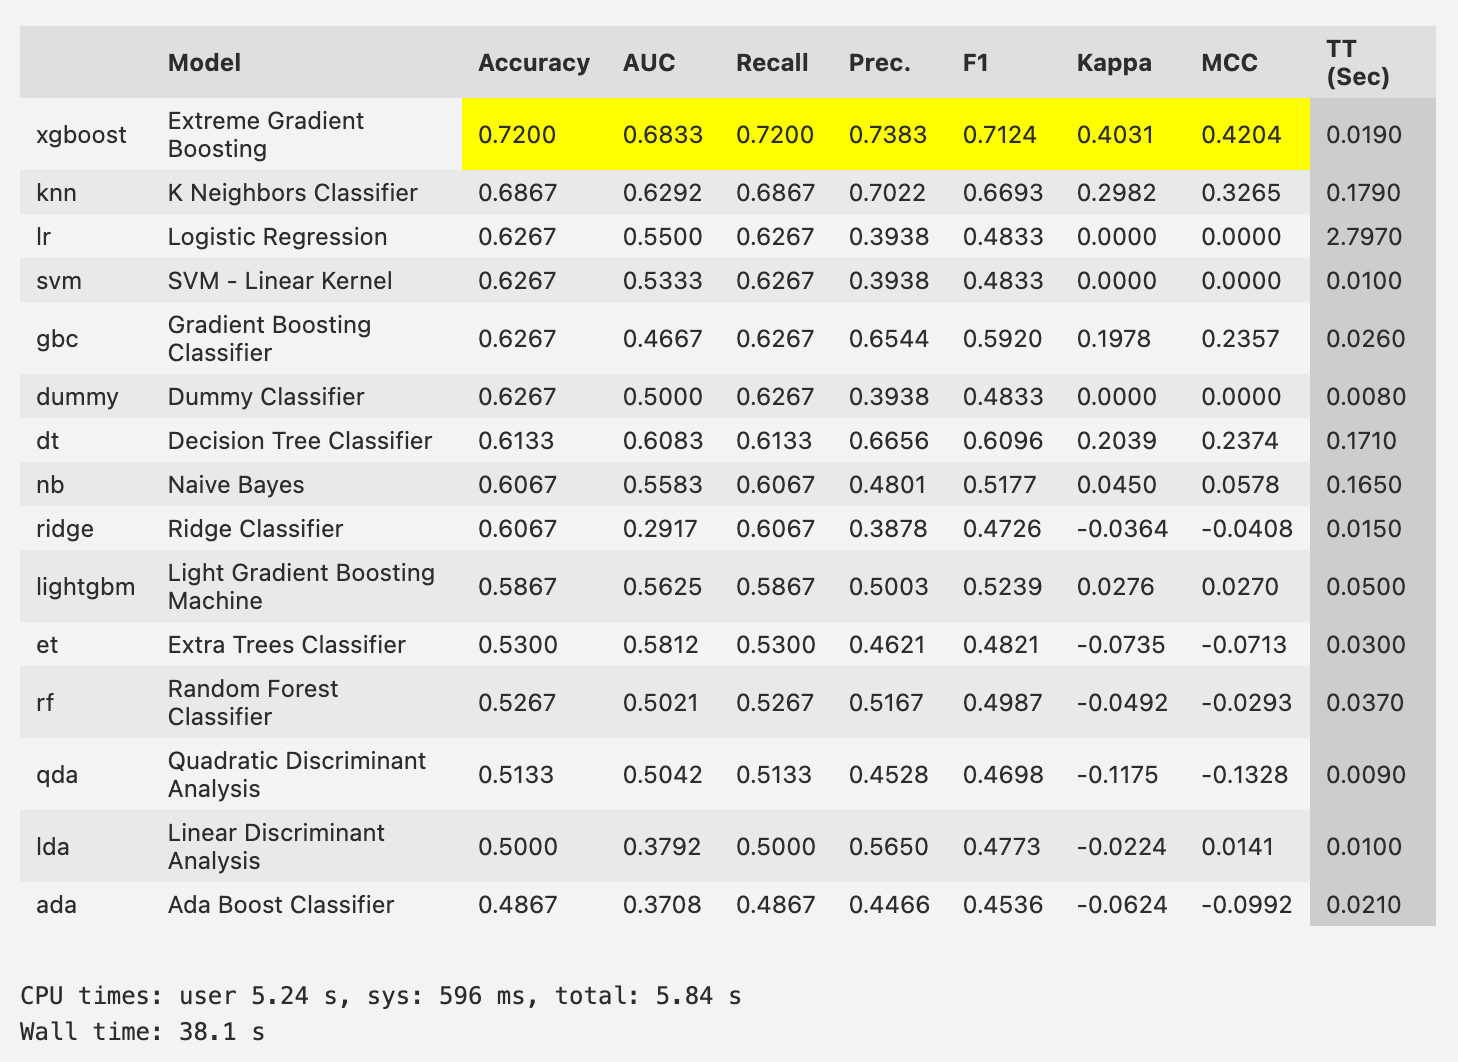

In [33]:
from IPython.display import Image, display
display(Image(filename='../assets/pycaret-compare-models-morphometry-only.png', width=800))


In [34]:
best_model

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

In [35]:
# Run XGBoost model  (here, slightly better than Dummy Classifier)
xgb1 = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.6667,0.7500,0.6667,0.6667,0.6667,0.2500,0.2500
2,0.6667,0.5000,0.6667,0.8333,0.6667,0.4000,0.5000
3,0.6667,0.7500,0.6667,0.6667,0.6667,0.2500,0.2500
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.4000,0.1667,0.4000,0.3000,0.3429,-0.3636,-0.4082
6,0.6000,0.6667,0.6000,0.6000,0.6000,0.1667,0.1667
7,0.6000,0.5000,0.6000,0.6000,0.6000,0.1667,0.1667
8,0.8000,0.8333,0.8000,0.8667,0.8000,0.6154,0.6667


In [36]:
# Run RandomForest model  (here, slightly worse than Dummy Classifier)
rf1 = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8333,1.0000,0.8333,0.8889,0.8381,0.6667,0.7071
1,0.6667,0.3750,0.6667,0.4444,0.5333,0.0000,0.0000
2,0.6667,0.6250,0.6667,0.8333,0.6667,0.4000,0.5000
3,0.5000,0.4375,0.5000,0.4000,0.4444,-0.2857,-0.3162
4,0.8000,1.0000,0.8000,0.8500,0.7810,0.5455,0.6124
5,0.2000,0.0000,0.2000,0.2000,0.2000,-0.6667,-0.6667
6,0.2000,0.0000,0.2000,0.2000,0.2000,-0.6667,-0.6667
7,0.2000,0.3333,0.2000,0.2000,0.2000,-0.6667,-0.6667
8,0.8000,0.6667,0.8000,0.8500,0.7810,0.5455,0.6124


### Model `prediction`  with the best_model (using the test set)

The `pred_best = predict_model(best_model)` line in PyCaret is used to generate predictions using the best model that was previously trained. Let's break down what this function does:

1. Purpose:
   - `predict_model()` is a PyCaret function used to make predictions on new or existing data using a trained model.

2. Input:
   - `best_model`: This is typically the model object returned by functions like `create_model()`, `tune_model()`, or `compare_models()`. It represents the trained model you want to use for predictions.

3. Default Behavior:
   - By default, if no new data is provided, `predict_model()` will **use the test set** that was automatically created during the `setup()` phase.

4. Output (pred_best):
   - The function returns a pandas DataFrame containing the original features, the true target values (if available), and the model's predictions.
   - It typically includes columns like:
     - Original features
     - 'Outcome' or your target column name (if available in the test set)
     - 'prediction_label': The predicted class labels
     - 'prediction_score': The probability scores for the predicted class (for classification tasks)

5. Additional Information:
   - For classification tasks, it provides probability scores for each class.
   - For regression tasks, it provides the predicted values.

6. Customization:
   - You can pass additional parameters to `predict_model()` to customize its behavior, such as specifying new data, changing the probability threshold for classification, etc.

7. Example usage:
   ```python
   # Assuming 'best_model' is your trained model
   predictions = predict_model(best_model)
   
   # To predict on new data
   new_predictions = predict_model(best_model, data=new_data)
   ```

8. Interpretation:
   - The resulting DataFrame allows you to compare the predicted values with the actual values (if available) and analyze the model's performance on the test set or new data.

9. Further Analysis:
   - After getting the predictions, you can use this DataFrame for various purposes like calculating additional metrics, creating visualizations, or performing error analysis.

In summary, `pred_best = predict_model(best_model)` generates predictions using your best model on the test set (or provided data), giving you a comprehensive DataFrame that includes both the original features and the model's predictions. This is crucial for evaluating your model's performance and understanding how it's making predictions on unseen data.

In [37]:
print(f'\n --> Model prediction with the best_model1 (df1_test):')
pred_best = predict_model(best_model)
#pred_best = predict_model(xgb1)
pred_best


 --> Model prediction with the best_model1 (df1_test):


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5000,0.3185,0.5000,0.4368,0.4580,-0.1707,-0.1854


,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,Outcome,prediction_label,prediction_score
59,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,0.000340,...,0.163753,0.328875,0.153961,0.153661,0.307623,0.040059,0.455646,1_IBS,1_IBS,0.6057
55,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,0.000365,...,0.171678,0.343989,0.143806,0.142742,0.286548,0.040310,0.464761,1_IBS,1_IBS,0.9880
29,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,0.000573,...,0.176176,0.355739,0.161939,0.159616,0.321555,0.046860,0.480850,0_HC,0_HC,0.6353
3,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.170035,0.339791,0.167488,0.167184,0.334672,0.043766,0.446639,1_IBS,1_IBS,0.9930
22,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,0.000442,...,0.177963,0.356654,0.159832,0.160601,0.320433,0.044115,0.482682,0_HC,1_IBS,0.9934
6,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,0.000471,...,0.167949,0.337384,0.163091,0.160939,0.324030,0.045131,0.459258,1_IBS,1_IBS,0.9695
62,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,0.000405,...,0.174455,0.349376,0.139267,0.137228,0.276495,0.041054,0.466345,1_IBS,1_IBS,0.8355
46,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,0.000384,...,0.154182,0.312039,0.165654,0.160333,0.325987,0.040960,0.423745,1_IBS,1_IBS,0.6436
5,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,0.000398,...,0.174857,0.347890,0.134529,0.135851,0.270380,0.042538,0.476372,0_HC,1_IBS,0.9952
33,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,0.000419,...,0.163060,0.327638,0.149032,0.149140,0.298172,0.043886,0.448879,1_IBS,0_HC,0.5911


The `pred_best` object is a DataFrame containing the predictions from your best model. <br>
To explore its options and contents, you can use various pandas DataFrame methods. Here are some useful options:

1. View basic information:
   ```python
   print(pred_best.info())
   ```

2. Display the first few rows:
   ```python
   print(pred_best.head())
   ```

3. Get a summary of statistical properties:
   ```python
   print(pred_best.describe())
   ```

4. List column names:
   ```python
   print(pred_best.columns)
   ```

5. Check for null values:
   ```python
   print(pred_best.isnull().sum())
   ```

6. Get unique values in a specific column:
   ```python
   print(pred_best['column_name'].unique())
   ```

7. Group by a column and get summary statistics:
   ```python
   print(pred_best.groupby('column_name').mean())
   ```

8. Create a correlation matrix:
   ```python
   print(pred_best.corr())
   ```

9. Plot distributions:
   ```python
   pred_best.hist(figsize=(12,10))
   plt.show()
   ```

10. Access specific columns:
    ```python
    print(pred_best[['column1', 'column2']])
    ```

11. Filter rows based on conditions:
    ```python
    print(pred_best[pred_best['column_name'] > value])
    ```

12. Sort values:
    ```python
    print(pred_best.sort_values('column_name', ascending=False))
    ```

13. Get the index of the DataFrame, in our case df1:
    ```python
    print(pred_best.index)
    ```
   
You can replace 'column_name' with the actual column names in your DataFrame. These methods will help you explore and analyze the predictions and related data in `pred_best`.

In [38]:
print(pred_best.index.tolist())

[59, 55, 29, 3, 22, 6, 62, 46, 5, 33, 16, 42, 54, 50, 35, 8, 69, 48, 47, 63, 56, 13, 76, 14]


In [39]:
# Get the list of Subject IDs based on the best model prediction
BGA_list = df['Subject'][list(pred_best.index)]
# Same as df_test[['Subject','Index']]
# Check with df_test[['Subject','Index']]
BGA_list

59    BGA_145
55    BGA_141
29    BGA_084
3     BGA_050
22    BGA_076
6     BGA_055
62    BGA_151
46    BGA_107
5     BGA_053
33    BGA_089
16    BGA_067
42    BGA_099
54    BGA_139
50    BGA_128
35    BGA_091
8     BGA_057
69    BGA_160
48    BGA_114
47    BGA_110
63    BGA_152
56    BGA_142
13    BGA_064
76    BGA_171
14    BGA_065
Name: Subject, dtype: object

#### Extend the df_test with Subject IDs and probabilistic measures from the classifier output

In [40]:
# Make the pred_model a dataframe where the index is a separate columns denoted BGA
BGA_list = df_test['Subject']  # list(pred_best.index)

df_pred_best = pd.DataFrame()
#df_tuned_pred = pred_model.reset_index().copy()

# Get the probabilities of prediction
y_pred_proba = best_model.predict_proba(get_config('X_test'))

# Add the BGA column from df_fs corresponding to indexes in the BGA_list
df_pred_best['Subject'] = df_test['Subject']

# Reset index in pred_model
pred_best = pred_best.reset_index(drop=True)

# Add the columns of pred_model to df_pred
for col in pred_best.columns:
    df_pred_best[col] = pred_best[col]

df_pred_best['p(0)'] = y_pred_proba[:,0]
df_pred_best['p(1)'] = y_pred_proba[:,1]

# Rename the columns
df_pred_best = df_pred_best.rename(columns = {'Outcome': 'True', 'prediction_label': 'Predicted', 'prediction_score': 'max(p(0),p(1))'})
df_pred_best


,Subject,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,...,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,True,Predicted,"max(p(0),p(1))",p(0),p(1)
0,BGA_145,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,...,0.153961,0.153661,0.307623,0.040059,0.455646,1_IBS,1_IBS,0.6057,0.394304,0.605696
1,BGA_141,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,...,0.143806,0.142742,0.286548,0.040310,0.464761,1_IBS,1_IBS,0.9880,0.012047,0.987953
2,BGA_084,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,...,0.161939,0.159616,0.321555,0.046860,0.480850,0_HC,0_HC,0.6353,0.635333,0.364667
3,BGA_050,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,...,0.167488,0.167184,0.334672,0.043766,0.446639,1_IBS,1_IBS,0.9930,0.007036,0.992964
4,BGA_076,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,...,0.159832,0.160601,0.320433,0.044115,0.482682,0_HC,1_IBS,0.9934,0.006635,0.993365
5,BGA_055,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,...,0.163091,0.160939,0.324030,0.045131,0.459258,1_IBS,1_IBS,0.9695,0.030467,0.969533
6,BGA_151,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,...,0.139267,0.137228,0.276495,0.041054,0.466345,1_IBS,1_IBS,0.8355,0.164486,0.835514
7,BGA_107,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,...,0.165654,0.160333,0.325987,0.040960,0.423745,1_IBS,1_IBS,0.6436,0.356379,0.643621
8,BGA_053,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,...,0.134529,0.135851,0.270380,0.042538,0.476372,0_HC,1_IBS,0.9952,0.004850,0.995150
9,BGA_089,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,...,0.149032,0.149140,0.298172,0.043886,0.448879,1_IBS,0_HC,0.5911,0.591094,0.408906


#### Four representations of the confusion matrix (best_model applied to the test set)

In [41]:
df_pred_best[['True','Predicted']].value_counts()

True   Predicted
1_IBS  1_IBS        11
0_HC   1_IBS         8
1_IBS  0_HC          4
0_HC   0_HC          1
Name: count, dtype: int64

In [42]:
# Make a cross tabulation of True and Predicted
pd.crosstab(df_pred_best['True'], df_pred_best['Predicted'])

Predicted,0_HC,1_IBS
True,,
0_HC,1,8
1_IBS,4,11


In [43]:
cm = confusion_matrix(df_pred_best['True'], df_pred_best['Predicted'])
print(cm)

[[ 1  8]
 [ 4 11]]


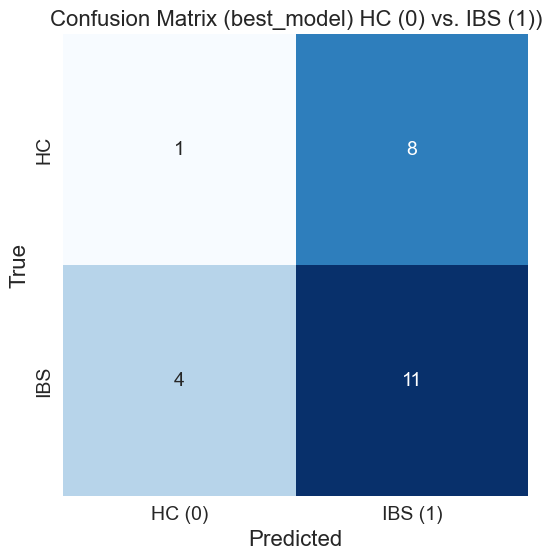

In [44]:
# Plot the confusion matrix from df_pred    

cm = confusion_matrix(df_pred_best['True'], df_pred_best['Predicted'])   # , labels=['0_NotImpaired', '1_Impaired'])

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})


ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (best_model) HC (0) vs.IBS (1))', fontsize=16)
ax.set_title('Confusion Matrix (best_model) HC (0) vs. IBS (1))', fontsize=16)

ax.set_xticklabels(['HC (0)', 'IBS (1)'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=14)


# Increase xlabel and ylabel size
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)


plt.show()

In [45]:
print(cm[1,1], cm[0,1], cm[1,0], cm[0,0])

11 8 4 1


### Classifier performance measures

In [46]:
# True Positive (TP)
TP = cm[1, 1]
# True Negative (TN)
TN = cm[0, 0]
# False Positive (FP)
FP = cm[0, 1]
# False Negative (FN)
FN = cm[1, 0]

print(f'TP (true positive i.e. M (1)) = {TP}\nTN (true negative i.e. F (0)) = {TN}\nFP (false pos.) = {FP}\nFN (false neg.) = {FN}\n')

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

# Balanced accuracy
BACC = (TPR + TNR)/2

#F1-score
F1 = 2/((1/PPV) + (1/TPR))
#F1 = 2*TP /(2*TP+FP+FN)
#F1 = 2*PPV*TPR/(PPV+TPR)

# Matthews correlation coefficient
MCC = ((TP*TN)-(FP*FN)) /np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

# Loop through the variables and print them with 2 decimals and preceede with variable name as string
var_names = ['TPR = TP/(TP+FN) (true positive rate, sensitivity, recall)', 
             'TNR = TN/(TN+FP) (true negative rate, specificity)', 
             'PPV = TP/(TP+FP) (positive predictive value, precision)', 
             'NPV = TN/(TN+FN) (negative predictive value)', 
             'FPR = FP/(FP+TN) (false positive rate)', 
             'FNR = FN/(TP+FN) (false negative rate)', 
             'FDR = FP/(TP+FP) (false discovery rate)', 
             'ACC = (TP+TN)/(TP+FP+FN+TN) (accuracy)',
             'BACC = (Sensitivity + Specificity) / 2 (balanced accuracy)',
             'F1 = 1/((1/PPV) + (1/TPR)) (F1-score, harmonic mean of precison and recall)',
             'MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))']
for i, var in enumerate([TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC, BACC,F1, MCC]):
    print(var_names[i],'=', "{:.2f}".format(var))
    

TP (true positive i.e. M (1)) = 11
TN (true negative i.e. F (0)) = 1
FP (false pos.) = 8
FN (false neg.) = 4

TPR = TP/(TP+FN) (true positive rate, sensitivity, recall) = 0.73
TNR = TN/(TN+FP) (true negative rate, specificity) = 0.11
PPV = TP/(TP+FP) (positive predictive value, precision) = 0.58
NPV = TN/(TN+FN) (negative predictive value) = 0.20
FPR = FP/(FP+TN) (false positive rate) = 0.89
FNR = FN/(TP+FN) (false negative rate) = 0.27
FDR = FP/(TP+FP) (false discovery rate) = 0.42
ACC = (TP+TN)/(TP+FP+FN+TN) (accuracy) = 0.50
BACC = (Sensitivity + Specificity) / 2 (balanced accuracy) = 0.42
F1 = 1/((1/PPV) + (1/TPR)) (F1-score, harmonic mean of precison and recall) = 0.65
MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) = -0.19


In [47]:
print(df_pred_best.columns)

Index(['Subject', 'eTIV', 'Left-Cerebellum-White-Matter',
       'Left-Cerebellum-Cortex', 'Left-Thalamus', 'Left-Caudate',
       'Left-Putamen', 'Left-Pallidum', 'Left-Hippocampus', 'Left-Amygdala',
       'Left-Accumbens-area', 'CSF', 'Right-Cerebellum-White-Matter',
       'Right-Cerebellum-Cortex', 'Right-Thalamus', 'Right-Caudate',
       'Right-Putamen', 'Right-Pallidum', 'Right-Hippocampus',
       'Right-Amygdala', 'Right-Accumbens-area', 'WM-hypointensities',
       'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central', 'CC_Mid_Anterior',
       'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent', 'lhCortexVol',
       'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol', 'True', 'Predicted', 'max(p(0),p(1))', 'p(0)', 'p(1)'],
      dtype='object')


#### Some book-keeping, modified from the IBS-distress project, for imputation of IBS_SSS

In [48]:
df_pred1 = df_pred_best.copy()
df_fs = df.copy()

print(df_fs['IBS_SSS'].value_counts())

IBS_SSS
0.0      3
233.0    2
405.0    2
264.0    2
208.0    2
        ..
418.0    1
16.0     1
325.0    1
277.0    1
53.0     1
Name: count, Length: 65, dtype: int64


In [49]:
# Assuming df_fs is your DataFrame containing the 'Subject' and 'IBS_SSS' columns
missing_IBS_SSS = sorted(df_fs[df_fs['IBS_SSS'].isna()]['Subject'].tolist())

print("BGA Subject values with missing IBS_SSS:")
print(missing_IBS_SSS)

BGA Subject values with missing IBS_SSS:
['BGA_056', 'BGA_062', 'BGA_081', 'BGA_092', 'BGA_110', 'BGA_114']


In [50]:
# Get the BG_ID for which IBS SSS is in the list
df_fs[df_fs['Subject'].isin(missing_IBS_SSS)][['Subject','IBS_SSS', 'Age', 'Gender', 'Group']]

,Subject,IBS_SSS,Age,Gender,Group
7,BGA_056,NaN,52,F,IBS
12,BGA_062,NaN,26,F,IBS
26,BGA_081,NaN,49,F,HC
36,BGA_092,NaN,39,F,HC
47,BGA_110,NaN,22,M,HC
48,BGA_114,NaN,37,F,IBS


### Imputation of `IBS_SSS` according to Gender and Group

In [51]:
# Keeping the incomplete df_fs (including those with missing IBS_SSS)
df_fs_incomplete = df_fs.copy()

In [52]:
df_fs_incomplete['IBS_SSS'].describe()

count     72.000000
mean     186.166667
std      134.299644
min        0.000000
25%       32.750000
50%      217.000000
75%      281.000000
max      418.000000
Name: IBS_SSS, dtype: float64

**Perform the imputation of those subject with missing IBS_SSS using the median of those remaining subjects that have the same Group and Gender**

In [53]:
# Get the subjects with missing IBS_SSS
missing_subjects = df_fs[df_fs['Subject'].isin(missing_IBS_SSS)][['Subject','IBS_SSS', 'Age', 'Gender', 'Group']]
print("Subjects with missing IBS_SSS:")
print(missing_subjects)
print()

# Function to calculate median IBS_SSS for a specific group and gender
def get_median_ibs_sss(group, gender):
    return df_fs[(df_fs['Group'] == group) & 
                 (df_fs['Gender'] == gender) & 
                 df_fs['IBS_SSS'].notna()]['IBS_SSS'].median()

# Perform imputation
for index, row in missing_subjects.iterrows():
    median_ibs_sss = get_median_ibs_sss(row['Group'], row['Gender'])
    df_fs.loc[index, 'IBS_SSS'] = np.round(median_ibs_sss, 0)
    print(f"Imputed IBS_SSS for {row['Subject']} (Group {row['Group']} {row['Gender']}): {median_ibs_sss:.0f}")

# Verify imputation
print("\nAfter imputation:")
print(df_fs[df_fs['Subject'].isin(missing_IBS_SSS)][['Subject','IBS_SSS', 'Age', 'Gender', 'Group']])

# Print overall statistics
print("\nOverall statistics of IBS_SSS after imputation:")
df_fs['IBS_SSS'].describe()

Subjects with missing IBS_SSS:
    Subject  IBS_SSS  Age Gender Group
7   BGA_056      NaN   52      F   IBS
12  BGA_062      NaN   26      F   IBS
26  BGA_081      NaN   49      F    HC
36  BGA_092      NaN   39      F    HC
47  BGA_110      NaN   22      M    HC
48  BGA_114      NaN   37      F   IBS

Imputed IBS_SSS for BGA_056 (Group IBS F): 267
Imputed IBS_SSS for BGA_062 (Group IBS F): 267
Imputed IBS_SSS for BGA_081 (Group HC F): 26
Imputed IBS_SSS for BGA_092 (Group HC F): 26
Imputed IBS_SSS for BGA_110 (Group HC M): 12
Imputed IBS_SSS for BGA_114 (Group IBS F): 267

After imputation:
    Subject  IBS_SSS  Age Gender Group
7   BGA_056    267.0   52      F   IBS
12  BGA_062    267.0   26      F   IBS
26  BGA_081     26.0   49      F    HC
36  BGA_092     26.0   39      F    HC
47  BGA_110     12.0   22      M    HC
48  BGA_114    267.0   37      F   IBS

Overall statistics of IBS_SSS after imputation:


count     78.000000
mean     182.935897
std      133.922476
min        0.000000
25%       29.750000
50%      217.000000
75%      269.250000
max      418.000000
Name: IBS_SSS, dtype: float64

In [54]:
# Print some additional information
print("\nNumber of valid IBS_SSS scores:")
valid_scores = df_fs['IBS_SSS'].notna()
print(f"{valid_scores.sum()} out of {len(valid_scores)}")


Number of valid IBS_SSS scores:
78 out of 78


In [55]:
df_fs


,Subject,Group,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,...,Fullscale_RBANS,Memory_Index,Visuospatial_Index,Verbalskills_Index,Attention_Index,Recall_Index,IBS_SSS,Age,Gender,Education
0,BGA_046,IBS,1.743419e+06,0.009292,0.034808,0.005048,0.002424,0.003358,0.001248,0.003099,...,100,80,102,93,97,86,195.0,38,M,12.0
1,BGA_047,IBS,1.360311e+06,0.009960,0.039399,0.005439,0.002127,0.002992,0.001318,0.002999,...,116,109,107,97,115,126,325.0,19,F,13.0
2,BGA_048,IBS,1.350452e+06,0.011099,0.037770,0.005755,0.002750,0.004094,0.001498,0.003533,...,95,83,84,113,103,100,326.0,34,F,13.0
3,BGA_050,IBS,1.595000e+06,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,...,87,86,97,90,98,86,357.0,44,F,18.0
4,BGA_051,IBS,1.645577e+06,0.010128,0.034373,0.005717,0.002209,0.003332,0.001317,0.002864,...,100,105,90,97,108,100,293.0,38,M,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,BGA_166,HC,1.399586e+06,0.011516,0.034967,0.005952,0.002364,0.003272,0.001358,0.002845,...,93,89,90,118,108,82,56.0,19,F,NaN
74,BGA_167,HC,1.394849e+06,0.011416,0.031906,0.005171,0.002180,0.003092,0.001154,0.002759,...,97,83,85,116,113,23,25.0,52,F,NaN
75,BGA_168,HC,1.259360e+06,0.012970,0.041197,0.006277,0.003057,0.004054,0.001500,0.003182,...,100,100,103,107,86,104,21.0,50,F,NaN
76,BGA_171,HC,1.609011e+06,0.010545,0.040919,0.005930,0.002501,0.003863,0.001624,0.002967,...,96,89,102,85,101,110,32.0,21,M,NaN


In [56]:
# Save the df_fs with imputed IBS_SSS
df_fs.to_csv('../data/demographics_fs7_rbans_IBS_SSS_imputed_78x48.csv', index=False)

#### Preparing for an extensively annotated confusion matix

In [57]:
# Find BGA for each of the quadrants of the confusion matrix

BGA_TP = list(df_pred1[(df_pred1['Predicted'] == '1_IBS') & (df_pred1['True'] == '1_IBS')]['Subject'])
BGA_TN = list(df_pred1[(df_pred1['Predicted'] == '0_HC') & (df_pred1['True'] == '0_HC')]['Subject'])
BGA_FP = list(df_pred1[(df_pred1['Predicted'] == '1_IBS') & (df_pred1['True'] == '0_HC')]['Subject'])
BGA_FN = list(df_pred1[(df_pred1['Predicted'] == '0_HC') & (df_pred1['True'] == '1_IBS')]['Subject'])

print(f'BGA_TP: {BGA_TP} (n={len(BGA_TP)})')
print(f'BGA_TN: {BGA_TN} (n={len(BGA_TN)})')
print(f'BGA_FP: {BGA_FP} (n={len(BGA_FP)})')
print(f'BGA_FN: {BGA_FN} (n={len(BGA_FN)})')

# Find IBS-SSS in df_fs  for which BGA is in BGA_TP
IBS_SSS_TP = df_fs[df_fs['Subject'].isin(BGA_TP)]['IBS_SSS']
IBS_SSS_TN = df_fs[df_fs['Subject'].isin(BGA_TN)]['IBS_SSS'] 
IBS_SSS_FP = df_fs[df_fs['Subject'].isin(BGA_FP)]['IBS_SSS']
IBS_SSS_FN = df_fs[df_fs['Subject'].isin(BGA_FN)]['IBS_SSS']

# Find summary statistics of IBS-SSS for each of the quadrants of the confusion matrix
print(f"TP (IBS-SSS mean (std)): {IBS_SSS_TP.mean().round(1)} (±{IBS_SSS_TP.std().round(1)})")
print(f"TN (IBS-SSS mean (std)): {IBS_SSS_TN.mean().round(1)} (±{IBS_SSS_TN.std().round(1)})")
print(f"FP (IBS-SSS mean (std)): {IBS_SSS_FP.mean().round(1)} (±{IBS_SSS_FP.std().round(1)})")
print(f"FN (IBS-SSS mean (std)): {IBS_SSS_FN.mean().round(1)} (±{IBS_SSS_FN.std().round(1)})")

# Find Age in df_fs for which BGA is in BGA_TP
AGE_TP = df_fs[df_fs['Subject'].isin(BGA_TP)]['Age']
AGE_TN = df_fs[df_fs['Subject'].isin(BGA_TN)]['Age'] 
AGE_FP = df_fs[df_fs['Subject'].isin(BGA_FP)]['Age']
AGE_FN = df_fs[df_fs['Subject'].isin(BGA_FN)]['Age']

# Find summary statistics of IBS-SSS for each of the quadrants of the confusion matrix
print(f"TP (Age mean (std)): {AGE_TP.mean().round(1)} (±{AGE_TP.std().round(1)})")
print(f"TN (Age mean (std)): {AGE_TN.mean().round(1)} (±{AGE_TN.std().round(1)})")
print(f"FP (Age mean (std)): {AGE_FP.mean().round(1)} (±{AGE_FP.std().round(1)})")
print(f"FN (Age mean (std)): {AGE_FN.mean().round(1)} (±{AGE_FN.std().round(1)})")


# Intialize value counts to 0 for each Group HC and IBS

# Find Gender (GROUP) in df_fs  for which BGA is in BGA_TP
Gender_TP = df_fs[df_fs['Subject'].isin(BGA_TP)].groupby(['Gender'])
Gender_TN = df_fs[df_fs['Subject'].isin(BGA_TN)].groupby(['Gender']) 
Gender_FP = df_fs[df_fs['Subject'].isin(BGA_FP)].groupby(['Gender'])
Gender_FN = df_fs[df_fs['Subject'].isin(BGA_FN)].groupby(['Gender'])


def ensure_F_M(group_counts):
    group_counts['F'] = group_counts.get('F', 0)
    group_counts['M'] = group_counts.get('M', 0)
    return group_counts

# For TP
Gender_TP_counts = Gender_TP.size().reset_index(name='count').set_index('Gender')['count'].to_dict()
Gender_TP_counts = ensure_F_M(Gender_TP_counts)
F_TP = Gender_TP_counts['F']
M_TP = Gender_TP_counts['M']

# For TN
Gender_TN_counts = Gender_TN.size().reset_index(name='count').set_index('Gender')['count'].to_dict()
Gender_TN_counts = ensure_F_M(Gender_TN_counts)
F_TN = Gender_TN_counts['F']
M_TN = Gender_TN_counts['M']

# For FP
Gender_FP_counts = Gender_FP.size().reset_index(name='count').set_index('Gender')['count'].to_dict()
Gender_FP_counts = ensure_F_M(Gender_FP_counts)
F_FP = Gender_FP_counts['F']
M_FP = Gender_FP_counts['M']

# For FN
Gender_FN_counts = Gender_FN.size().reset_index(name='count').set_index('Gender')['count'].to_dict()
Gender_FN_counts = ensure_F_M(Gender_FN_counts)
F_FN = Gender_FN_counts['F']
M_FN = Gender_FN_counts['M']

print("Gender_TP_counts:", Gender_TP_counts)
print("Gender_TN_counts:", Gender_TN_counts)
print("Gender_FP_counts:", Gender_FP_counts)
print("Gender_FN_counts:", Gender_FN_counts)

print(f"TP: F = {F_TP}, M = {M_TP}")
print(f"TN: F = {F_TN}, M = {M_TN}")
print(f"FP: F = {F_FP}, M = {M_FP}")
print(f"FN: F = {F_FN}, M = {M_FN}")

BGA_TP: ['BGA_145', 'BGA_141', 'BGA_050', 'BGA_055', 'BGA_151', 'BGA_107', 'BGA_067', 'BGA_128', 'BGA_160', 'BGA_114', 'BGA_152'] (n=11)
BGA_TN: ['BGA_084'] (n=1)
BGA_FP: ['BGA_076', 'BGA_053', 'BGA_099', 'BGA_091', 'BGA_110', 'BGA_064', 'BGA_171', 'BGA_065'] (n=8)
BGA_FN: ['BGA_089', 'BGA_139', 'BGA_057', 'BGA_142'] (n=4)
TP (IBS-SSS mean (std)): 245.7 (±60.4)
TN (IBS-SSS mean (std)): 21.0 (±nan)
FP (IBS-SSS mean (std)): 19.2 (±19.6)
FN (IBS-SSS mean (std)): 335.0 (±93.3)
TP (Age mean (std)): 33.2 (±7.6)
TN (Age mean (std)): 23.0 (±nan)
FP (Age mean (std)): 25.4 (±5.7)
FN (Age mean (std)): 39.8 (±8.6)
Gender_TP_counts: {'F': 8, 'M': 3}
Gender_TN_counts: {'F': 1, 'M': 0}
Gender_FP_counts: {'F': 3, 'M': 5}
Gender_FN_counts: {'F': 3, 'M': 1}
TP: F = 8, M = 3
TN: F = 1, M = 0
FP: F = 3, M = 5
FN: F = 3, M = 1


In [58]:
print(IBS_SSS_TP.to_list())

[357.0, 158.0, 178.0, 228.0, 267.0, 231.0, 298.0, 236.0, 304.0, 181.0, 265.0]


In [59]:
print("Unique values in 'True' column:", df_pred_best['True'].unique())
print("Unique values in 'Predicted' column:", df_pred_best['Predicted'].unique())

Unique values in 'True' column: ['1_IBS', '0_HC']
Categories (2, object): ['0_HC', '1_IBS']
Unique values in 'Predicted' column: ['1_IBS' '0_HC']


### Figure: Confusion matrix with annotations

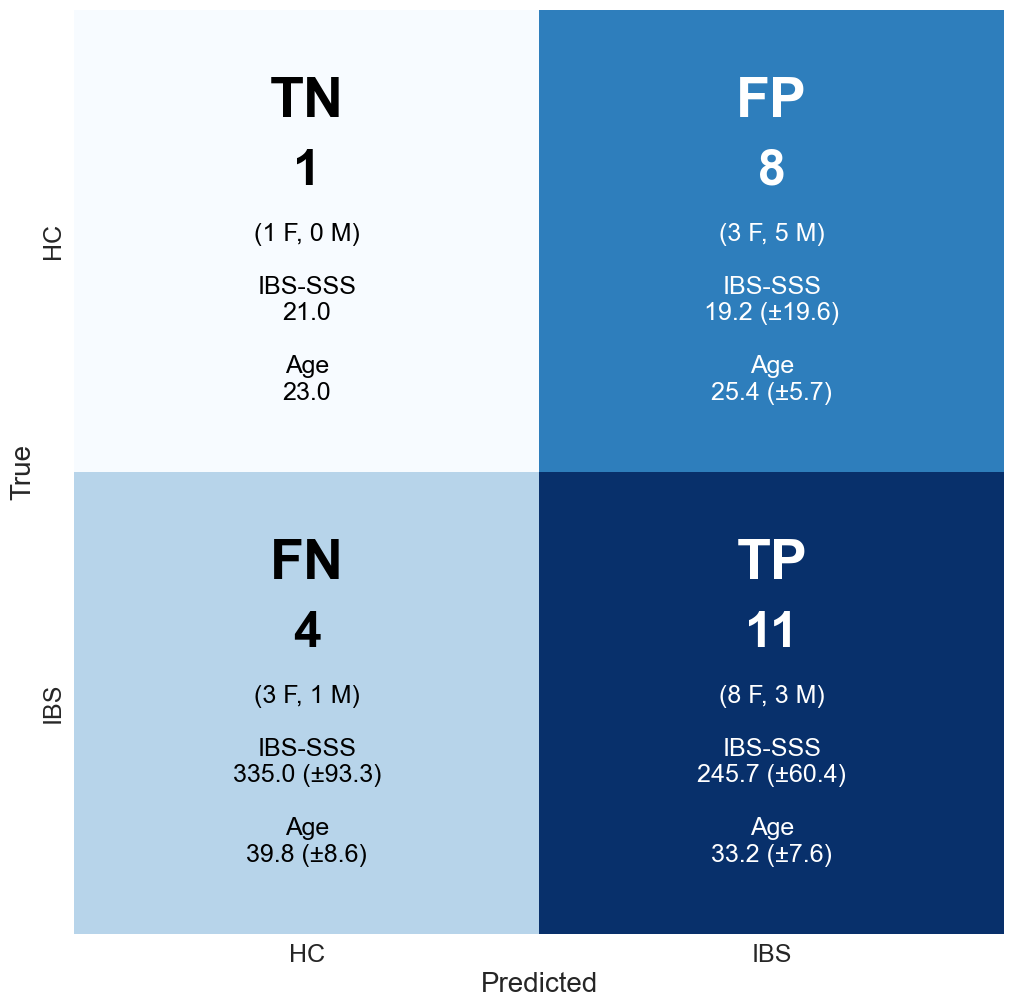

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix from df_pred    
cm = confusion_matrix(df_pred_best['True'], df_pred_best['Predicted'], labels=['0_HC', '1_IBS'])

fig, ax = plt.subplots(figsize=(12, 12))  

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})

# Coordinates for the text
coordinates = [(0, 0), (0, 1), (1, 0), (1, 1)]

def format_mean_std(mean, std):
    if np.isnan(std):
        return f"{mean:.1f}"
    else:
        return f"{mean:.1f} (±{std:.1f})"

# Assuming cm is the confusion matrix
TN, FP, FN, TP = cm.ravel()
n_values = [TN, FP, FN, TP]

texts = [
    f'TN\n\n({F_TN} F, {M_TN} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_TN.mean(), IBS_SSS_TN.std())}\n\nAge\n{format_mean_std(AGE_TN.mean(), AGE_TN.std())}',
    f'FP\n\n({F_FP} F, {M_FP} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_FP.mean(), IBS_SSS_FP.std())}\n\nAge\n{format_mean_std(AGE_FP.mean(), AGE_FP.std())}',
    f'FN\n\n({F_FN} F, {M_FN} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_FN.mean(), IBS_SSS_FN.std())}\n\nAge\n{format_mean_std(AGE_FN.mean(), AGE_FN.std())}',
    f'TP\n\n({F_TP} F, {M_TP} M)\n\nIBS-SSS\n{format_mean_std(IBS_SSS_TP.mean(), IBS_SSS_TP.std())}\n\nAge\n{format_mean_std(AGE_TP.mean(), AGE_TP.std())}'
]
                                                                           
for text, (i, j), n in zip(texts, coordinates, n_values):
    # Determine text color
    if (i == 1 and j == 1) or (i == 0 and j == 1):  # TP or FP
        color = 'white'
    else:  # TN or FN
        color = 'black'
    
    # Display TN, FP, FN, TP in large font
    plt.text(j + 0.5, i + 0.2, text[:2], ha='center', va='center', color=color, fontsize=40, fontweight='bold')
    
    # Display n value
    plt.text(j + 0.5, i + 0.35, str(n), ha='center', va='center', color=color, fontsize=36, fontweight='bold')
    
    # Display other information
    plt.text(j + 0.5, i + 0.6, text[2:], ha='center', va='center', color=color, fontsize=18)

ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('') # 'Confusion Matrix (XGBOOST) predicting IBS from brain morphometry', fontsize=18)

ax.set_xticklabels(['HC', 'IBS'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=18)

# Increase xlabel and ylabel size
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)

plt.show()

fig.savefig('/Users/arvid/Dropbox/Apps/Overleaf/Evaluation_of_brain_morphometry_and_clinical_data_in_IBS_diagnostics/figs/annotated_xgboost_confusion_matrix_using_ASEG.png')

fig.savefig('../figs/annotated_xgboost_confusion_matrix_using_ASEG.png')



# Plot as pdf in hig res
fig.savefig('../figs/annotated_xgboost_confusion_matrix_using_ASEG.pdf', dpi=300)

## Feature importance

### XGBClassification: Gain

When `best_model` is an XGBClassifier (from the XGBoost library), the `feature_importances_` attribute provides a measure of feature importance based on the model's internal structure. For XGBoost, this typically refers to the "Gain" importance. Here's a breakdown of how it works:

1. Calculation Method:
   The `feature_importances_` in XGBoost is calculated using the "Gain" method by default. Gain represents the improvement in accuracy brought by a feature to the branches it is on.

2. Gain Importance:
   - For each feature, the gain is calculated as the improvement in accuracy that the feature brings.
   - This is done by measuring the loss reduction (or gain in the prediction accuracy) that comes from splitting on this feature.
   - The gain is accumulated for each feature across all trees in the ensemble.

3. Normalization:
   - The raw gain values are typically normalized so that the sum of all feature importances equals 1 (or 100%).
   - This normalization makes it easier to interpret the relative importance of features.

4. Interpretation:
   - Higher values indicate more important features.
   - The importance is relative, meaning a feature with importance 0.2 is twice as important for the model's predictions as a feature with importance 0.1.

5. Advantages:
   - It takes into account both the frequency of a feature being used for splitting and the improvement in accuracy it brings.
   - It's generally more reliable than just counting the number of times a feature is used for splitting.

6. Considerations:
   - This method can sometimes overestimate the importance of high-cardinality features (features with many unique values).
   - It doesn't capture feature interactions explicitly, though the tree structure does account for some interaction effects.

7. Accessing in XGBoost:
   ```python
   importances = best_model.feature_importances_
   ```

8. Alternative Methods:
   XGBoost also supports other feature importance methods like "Weight" (number of times a feature appears in trees) and "Cover" (number of samples affected by splits using the feature), but these are not directly accessible through the `feature_importances_` attribute.

It's worth noting that while `feature_importances_` provides valuable insights, it's often beneficial to use it in conjunction with other interpretability methods like SHAP values for a more comprehensive understanding of feature impacts in your XGBoost model.

In [61]:
importances1 = xgb1.feature_importances_
importances1.round(3)

array([0.075, 0.053, 0.009, 0.   , 0.   , 0.09 , 0.03 , 0.022, 0.041,
       0.01 , 0.064, 0.006, 0.059, 0.004, 0.063, 0.013, 0.02 , 0.039,
       0.07 , 0.004, 0.067, 0.006, 0.013, 0.004, 0.004, 0.016, 0.03 ,
       0.   , 0.   , 0.022, 0.   , 0.082, 0.062, 0.003, 0.009, 0.009],
      dtype=float32)

In [62]:
list(df1.columns)

['eTIV',
 'Left-Cerebellum-White-Matter',
 'Left-Cerebellum-Cortex',
 'Left-Thalamus',
 'Left-Caudate',
 'Left-Putamen',
 'Left-Pallidum',
 'Left-Hippocampus',
 'Left-Amygdala',
 'Left-Accumbens-area',
 'CSF',
 'Right-Cerebellum-White-Matter',
 'Right-Cerebellum-Cortex',
 'Right-Thalamus',
 'Right-Caudate',
 'Right-Putamen',
 'Right-Pallidum',
 'Right-Hippocampus',
 'Right-Amygdala',
 'Right-Accumbens-area',
 'WM-hypointensities',
 'CC_Posterior',
 'CC_Mid_Posterior',
 'CC_Central',
 'CC_Mid_Anterior',
 'CC_Anterior',
 'BrainSegVol',
 'BrainSegVolNotVent',
 'lhCortexVol',
 'rhCortexVol',
 'CortexVol',
 'lhCerebralWhiteMatterVol',
 'rhCerebralWhiteMatterVol',
 'CerebralWhiteMatterVol',
 'SubCortGrayVol',
 'TotalGrayVol',
 'Outcome']

In [63]:
# Find index of those with highest importance, sorted from largest to smallest:
indices1 = np.argsort(importances1)[::-1]
indices1

array([ 5, 31,  0, 18, 20, 10, 14, 32, 12,  1,  8, 17,  6, 26, 29,  7, 16,
       25, 15, 22,  9, 35,  2, 34, 21, 11, 24, 23, 13, 19, 33, 28, 27, 30,
        4,  3])

In [64]:
# Find index of those with highest importance, sorted from smallest to largest:
indices1 = np.argsort(importances1)
indices1

array([ 3,  4, 30, 27, 28, 33, 19, 13, 23, 24, 11, 21, 34,  2, 35,  9, 22,
       15, 25, 16,  7, 29, 26,  6, 17,  8,  1, 12, 32, 14, 10, 20, 18,  0,
       31,  5])

In [65]:
features1 = df1.drop('Outcome', axis=1)
for f in range(features1.shape[1]): 
    print(f'{df1.columns[indices1[f]]}: {np.round(importances1[indices1[f]],2)}')

Left-Thalamus: 0.0
Left-Caudate: 0.0
CortexVol: 0.0
BrainSegVolNotVent: 0.0
lhCortexVol: 0.0
CerebralWhiteMatterVol: 0.0
Right-Accumbens-area: 0.0
Right-Thalamus: 0.0
CC_Central: 0.0
CC_Mid_Anterior: 0.0
Right-Cerebellum-White-Matter: 0.009999999776482582
CC_Posterior: 0.009999999776482582
SubCortGrayVol: 0.009999999776482582
Left-Cerebellum-Cortex: 0.009999999776482582
TotalGrayVol: 0.009999999776482582
Left-Accumbens-area: 0.009999999776482582
CC_Mid_Posterior: 0.009999999776482582
Right-Putamen: 0.009999999776482582
CC_Anterior: 0.019999999552965164
Right-Pallidum: 0.019999999552965164
Left-Hippocampus: 0.019999999552965164
rhCortexVol: 0.019999999552965164
BrainSegVol: 0.029999999329447746
Left-Pallidum: 0.029999999329447746
Right-Hippocampus: 0.03999999910593033
Left-Amygdala: 0.03999999910593033
Left-Cerebellum-White-Matter: 0.05000000074505806
Right-Cerebellum-Cortex: 0.05999999865889549
rhCerebralWhiteMatterVol: 0.05999999865889549
Right-Caudate: 0.05999999865889549
CSF: 0.0599

### Feature importance (XGBClassification: Gain)

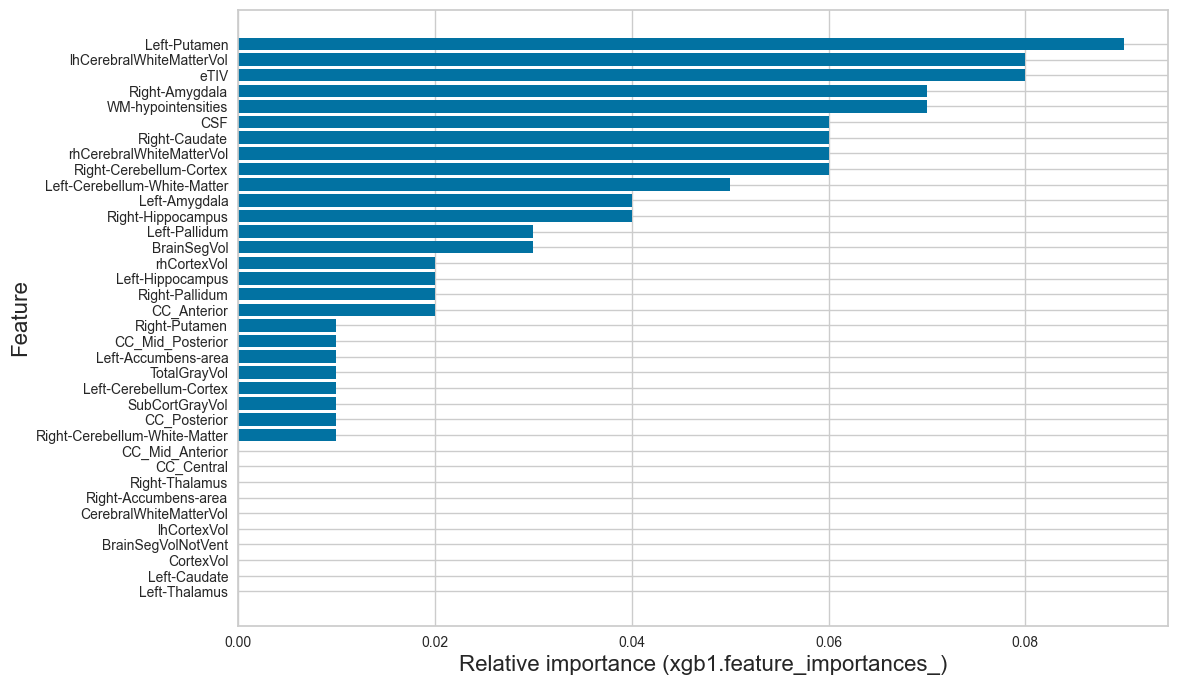

In [66]:
# Let's plot these results in a bar chart in descending order of importance
f, ax = plt.subplots(figsize=(12,8))
plt.barh(features1.columns[indices1], np.round(importances1[indices1],2))
plt.xlabel("Relative importance (xgb1.feature_importances_)", fontsize=16)
plt.ylabel("Feature", fontsize=16)

# Increase font of ytick labels to make them easier to read
plt.yticks(fontsize=10)

plt.show()

#f.savefig('../figs/Fig_4a_best_model_feature_importances_.png')

## Permutation importance

Permutation importance is a model-agnostic method to measure feature importance. It works by randomly shuffling the values of each feature and measuring how much this shuffling decreases the model's performance. The idea behind permutation importance is that if a feature is important for the predictions of a trained model, then a random shuffling of the data in the corresponding column should drastically reduce the model's accuracy. On the other hand, a random shuffling of an unimportant feature shouldn't impact the model much.

This method has several advantages:

- It's model-agnostic, meaning it can be used with any type of model, not just random forests.
- It takes into account feature interactions, unlike some other importance measures.
- It provides a measure of uncertainty through the standard deviation of importance scores.

NOTE: Different measurement methods:

- Gini impurity: This is calculated during the training of the Random Forest. It measures how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset.
- Permutation importance: This is calculated after the model is trained. It measures how much the model's performance decreases when a feature is randomly shuffled. The more the performance decreases, the more important the feature is.


In [67]:
df1_pred_xgb1 = df_pred1.copy()
df1_pred_xgb1

,Subject,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,...,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,True,Predicted,"max(p(0),p(1))",p(0),p(1)
0,BGA_145,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,...,0.153961,0.153661,0.307623,0.040059,0.455646,1_IBS,1_IBS,0.6057,0.394304,0.605696
1,BGA_141,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,...,0.143806,0.142742,0.286548,0.040310,0.464761,1_IBS,1_IBS,0.9880,0.012047,0.987953
2,BGA_084,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,...,0.161939,0.159616,0.321555,0.046860,0.480850,0_HC,0_HC,0.6353,0.635333,0.364667
3,BGA_050,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,...,0.167488,0.167184,0.334672,0.043766,0.446639,1_IBS,1_IBS,0.9930,0.007036,0.992964
4,BGA_076,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,...,0.159832,0.160601,0.320433,0.044115,0.482682,0_HC,1_IBS,0.9934,0.006635,0.993365
5,BGA_055,1515539.250,0.010847,0.037519,0.006125,0.002558,0.003617,0.001582,0.003030,0.001076,...,0.163091,0.160939,0.324030,0.045131,0.459258,1_IBS,1_IBS,0.9695,0.030467,0.969533
6,BGA_151,1524517.500,0.012734,0.036852,0.005207,0.002483,0.003720,0.001258,0.002635,0.001193,...,0.139267,0.137228,0.276495,0.041054,0.466345,1_IBS,1_IBS,0.8355,0.164486,0.835514
7,BGA_107,1823483.625,0.011333,0.035723,0.005280,0.002016,0.003682,0.001359,0.002694,0.001172,...,0.165654,0.160333,0.325987,0.040960,0.423745,1_IBS,1_IBS,0.6436,0.356379,0.643621
8,BGA_053,1505440.625,0.009660,0.042842,0.005335,0.002583,0.003881,0.001422,0.002835,0.001313,...,0.134529,0.135851,0.270380,0.042538,0.476372,0_HC,1_IBS,0.9952,0.004850,0.995150
9,BGA_089,1320594.750,0.010221,0.037912,0.005721,0.002176,0.003942,0.001385,0.003029,0.001351,...,0.149032,0.149140,0.298172,0.043886,0.448879,1_IBS,0_HC,0.5911,0.591094,0.408906


In [68]:
X_test = get_config('X_test')
y_true = get_config('y_test')
pred_xgb1 = predict_model(xgb1);
# y_pred = best_model.predict(X_test)  # HC=0, IBS=1
y_pred = df1_pred_xgb1['Predicted']
# y_pred = list(pred_best['prediction_label']) 
n_repeats = 30 
random_state = 123
X = df1.drop('Outcome', axis=1)

y_pred_numeric = [0 if x == '0_HC' else 1 for x in y_pred]
y_true_numeric = [0 if x == '0_HC' else 1 for x in y_true]

y_true_numeric

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.5000,0.3185,0.5000,0.4368,0.4580,-0.1707,-0.1854


[1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0]

In [69]:
print(type(pred_xgb1))
pred_xgb1.head()

<class 'pandas.core.frame.DataFrame'>


,eTIV,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,Left-Hippocampus,Left-Amygdala,Left-Accumbens-area,...,rhCortexVol,CortexVol,lhCerebralWhiteMatterVol,rhCerebralWhiteMatterVol,CerebralWhiteMatterVol,SubCortGrayVol,TotalGrayVol,Outcome,prediction_label,prediction_score
59,1580332.000,0.011314,0.041363,0.005163,0.002118,0.003422,0.001266,0.002767,0.001122,0.000340,...,0.163753,0.328875,0.153961,0.153661,0.307623,0.040059,0.455646,1_IBS,1_IBS,0.6057
55,1441712.000,0.010599,0.039928,0.004939,0.002347,0.003455,0.001261,0.003030,0.001155,0.000365,...,0.171678,0.343989,0.143806,0.142742,0.286548,0.040310,0.464761,1_IBS,1_IBS,0.9880
29,1479463.375,0.012270,0.038618,0.006195,0.003005,0.003942,0.001570,0.003204,0.001361,0.000573,...,0.176176,0.355739,0.161939,0.159616,0.321555,0.046860,0.480850,0_HC,0_HC,0.6353
3,1595000.250,0.010458,0.030902,0.005803,0.002675,0.003622,0.001322,0.002925,0.001137,0.000495,...,0.170035,0.339791,0.167488,0.167184,0.334672,0.043766,0.446639,1_IBS,1_IBS,0.9930
22,1533277.500,0.010784,0.040750,0.005667,0.002632,0.003825,0.001450,0.002884,0.001289,0.000442,...,0.177963,0.356654,0.159832,0.160601,0.320433,0.044115,0.482682,0_HC,1_IBS,0.9934


In [70]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Assuming you have a test set (validation set)
X_val = get_config('X_test')
y_val = y_true_numeric

# Use the existing predictions
y_pred = pred_xgb1  # Assuming this contains the predictions

# Convert y_val to a 1D numpy array of strings
y_val = np.array(y_val).astype(str).ravel()

# If y_pred is a DataFrame, extract the relevant column
if isinstance(y_pred, pd.DataFrame):
    y_pred = y_pred.iloc[:, 0]  # Assuming the predictions are in the first column

# Convert y_pred to a 1D numpy array of strings
y_pred = np.array(y_pred).astype(str).ravel()

# Print shapes for debugging
print("Shape of y_val:", y_val.shape)
print("Shape of y_pred:", y_pred.shape)

# Create a LabelEncoder
le = LabelEncoder()

# Fit the encoder on the union of unique values from both y_val and y_pred
unique_labels = np.unique(np.concatenate((y_val, y_pred)))
le.fit(unique_labels)

# Transform both y_val and y_pred
y_val_encoded = le.transform(y_val)
y_pred_encoded = le.transform(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_pred_encoded)
print(f"Model Accuracy: {accuracy:.3f}")

# Print some debug information
print("Original y_val unique values:", np.unique(y_val))
print("Original y_pred unique values:", np.unique(y_pred))
print("Encoded y_val unique values:", np.unique(y_val_encoded))
print("Encoded y_pred unique values:", np.unique(y_pred_encoded))
print("Label encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# If you want to see the first few values
print("\nFirst few values:")
print("Original y_val:", y_val[:5])
print("Encoded y_val:", y_val_encoded[:5])
print("Original y_pred:", y_pred[:5])
print("Encoded y_pred:", y_pred_encoded[:5])


Shape of y_val: (24,)
Shape of y_pred: (24,)
Model Accuracy: 0.000
Original y_val unique values: ['0' '1']
Original y_pred unique values: ['1224504.6' '1320594.8' '1379524.2' '1386840.1' '1403013.9' '1415589.1'
 '1417420.1' '1441712.0' '1467060.1' '1479463.4' '1505440.6' '1515539.2'
 '1524517.5' '1533277.5' '1544695.4' '1565479.8' '1570708.6' '1578283.5'
 '1580332.0' '1595000.2' '1609011.5' '1641094.9' '1762430.5' '1823483.6']
Encoded y_val unique values: [0 1]
Encoded y_pred unique values: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Label encoding mapping: {'0': 0, '1': 1, '1224504.6': 2, '1320594.8': 3, '1379524.2': 4, '1386840.1': 5, '1403013.9': 6, '1415589.1': 7, '1417420.1': 8, '1441712.0': 9, '1467060.1': 10, '1479463.4': 11, '1505440.6': 12, '1515539.2': 13, '1524517.5': 14, '1533277.5': 15, '1544695.4': 16, '1565479.8': 17, '1570708.6': 18, '1578283.5': 19, '1580332.0': 20, '1595000.2': 21, '1609011.5': 22, '1641094.9': 23, '1762430.5': 24, '18234

In [71]:
xgb1

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

#### On permutation importance

```python
result = permutation_importance(
    xgb1, X_val, y_val_encoded, 
    n_repeats=100, 
    random_state=42, 
    n_jobs=-1
)
```

This code is using the `permutation_importance` function from scikit-learn to calculate the permutation feature importance for a trained model. Here's what each part means:

1. `permutation_importance`: This is a model-agnostic method to calculate feature importance. It works by randomly shuffling each feature one at a time and measuring how much the model's performance decreases. The more the performance decreases, the more important the feature is.

2. `xgb1`: This is your trained XGBoost model.

3. `X_val`: This is your validation (or test) dataset, containing the feature values.

4. `y_val_encoded`: These are the true labels for your validation set, encoded as needed for the model.

5. `n_repeats=100`: This specifies how many times the permutation process should be repeated for each feature. More repeats give more reliable results but take longer to compute.

6. `random_state=42`: This sets a seed for the random number generator, ensuring reproducibility of results.

7. `n_jobs=-1`: This tells the function to use all available CPU cores to speed up the computation.

The function returns a `result` object that contains:

- `importances_mean`: The mean decrease in model score when a feature is permuted.
- `importances_std`: The standard deviation of the importance across different permutations.

This method is particularly useful because:

1. It's model-agnostic, meaning it can be used with any type of model, not just tree-based models.
2. It takes into account feature interactions, as it measures the impact on the model's overall performance.
3. It's performed on a separate validation set, so it gives you an idea of how important features are for generalizing to new data.

By using this method, you're getting a robust measure of feature importance that can help you understand which features are most crucial for your model's predictions.

In [72]:
X_val.shape

(24, 36)

Original y_val unique values: ['0' '1']
Original y_pred unique values: ['1224504.6' '1320594.8' '1379524.2' '1386840.1' '1403013.9' '1415589.1'
 '1417420.1' '1441712.0' '1467060.1' '1479463.4' '1505440.6' '1515539.2'
 '1524517.5' '1533277.5' '1544695.4' '1565479.8' '1570708.6' '1578283.5'
 '1580332.0' '1595000.2' '1609011.5' '1641094.9' '1762430.5' '1823483.6']
Encoded y_val unique values: [0 1]
Encoded y_pred unique values: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25]
Label encoding mapping: {'0': 0, '1': 1, '1224504.6': 2, '1320594.8': 3, '1379524.2': 4, '1386840.1': 5, '1403013.9': 6, '1415589.1': 7, '1417420.1': 8, '1441712.0': 9, '1467060.1': 10, '1479463.4': 11, '1505440.6': 12, '1515539.2': 13, '1524517.5': 14, '1533277.5': 15, '1544695.4': 16, '1565479.8': 17, '1570708.6': 18, '1578283.5': 19, '1580332.0': 20, '1595000.2': 21, '1609011.5': 22, '1641094.9': 23, '1762430.5': 24, '1823483.6': 25}

First few values:
Original y_val: ['1' '1' '0' '1' '0']

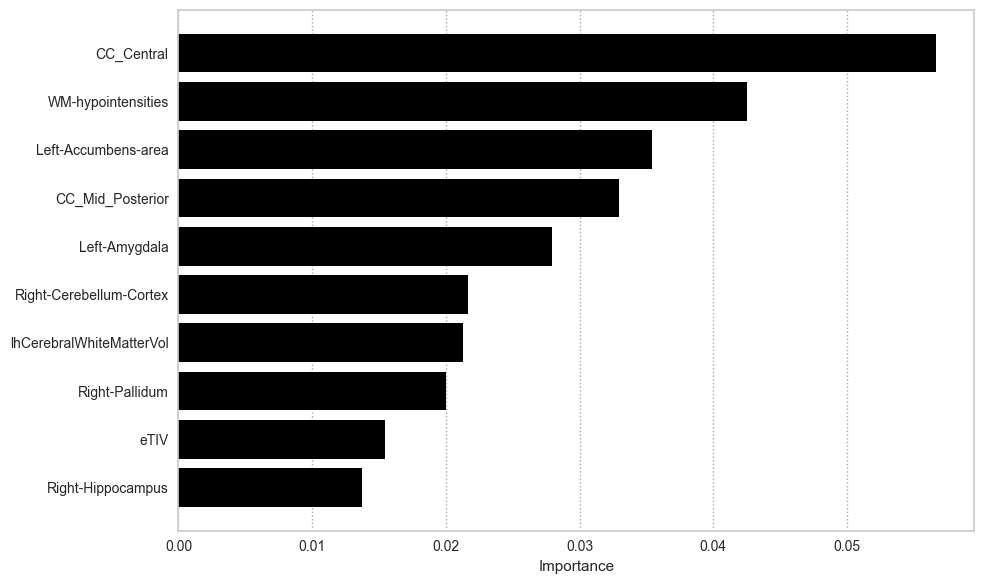

CPU times: user 1.76 s, sys: 2.6 s, total: 4.35 s
Wall time: 4.84 s


In [73]:
%%time
# Compute permutation importance

n_repeats = 100

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
import numpy as np
import pandas as pd

# ... [Your existing code up to accuracy calculation] ...

# Print some debug information
print("Original y_val unique values:", np.unique(y_val))
print("Original y_pred unique values:", np.unique(y_pred))
print("Encoded y_val unique values:", np.unique(y_val_encoded))
print("Encoded y_pred unique values:", np.unique(y_pred_encoded))
print("Label encoding mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# If you want to see the first few values
print("\nFirst few values:")
print("Original y_val:", y_val[:5])
print("Encoded y_val:", y_val_encoded[:5])
print("Original y_pred:", y_pred[:5])
print("Encoded y_pred:", y_pred_encoded[:5])

# Compute permutation importance
# Note: We need the actual model for this, not just predictions
# Assuming 'xgb1' is your trained model
result = permutation_importance(
    xgb1, X_val, y_val_encoded, 
    n_repeats=n_repeats, 
    random_state=42, 
    n_jobs=-1
)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X_val.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
})

# Sort features by importance
feature_importance = feature_importance.sort_values('importance', ascending=False).reset_index(drop=True)

# Print top 10 important features
print("\nTop 10 important features (permutation importance) - brain morphometry:")
print(feature_importance.head(10))

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10][::-1], feature_importance['importance'][:10][::-1], color='black')
plt.xlabel('Importance')
plt.title('') # f'Top 10 Feature Importances (permutation importance, {n_repeats} repeats) - brain morphometry')

# Set white background
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Add horizontal dotted gridlines
plt.grid(axis='x', linestyle=':', color='gray', alpha=0.7)

# Remove vertical gridlines
plt.gca().yaxis.grid(False)

# Adjust layout and display
plt.tight_layout()


# Save to png and high res pdf
plt.savefig('../figs/Top_10_Feature_Importances_permutation_importance_brain_morphometry.png')

# Direct to figs folder on Overleaf as .png
plt.savefig('/Users/arvid/Dropbox/Apps/Overleaf/Evaluation_of_brain_morphometry_and_clinical_data_in_IBS_diagnostics/figs/Top_10_Feature_Importances_permutation_importance_brain_morphometry.png')

plt.savefig('../figs/Top_10_Feature_Importances_permutation_importance_brain_morphometry.pdf', dpi=300)

# Direct to figs folder on Overleaf as .pdf
plt.savefig('/Users/arvid/Dropbox/Apps/Overleaf/Evaluation_of_brain_morphometry_and_clinical_data_in_IBS_diagnostics/figs/Top_10_Feature_Importances_permutation_importance_brain_morphometry.pdf', dpi=300)

plt.show()

In [74]:
# All features:
print('Number of features:', X_val.shape[1])
X_val.columns

Number of features: 36


Index(['eTIV', 'Left-Cerebellum-White-Matter', 'Left-Cerebellum-Cortex',
       'Left-Thalamus', 'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       'Left-Hippocampus', 'Left-Amygdala', 'Left-Accumbens-area', 'CSF',
       'Right-Cerebellum-White-Matter', 'Right-Cerebellum-Cortex',
       'Right-Thalamus', 'Right-Caudate', 'Right-Putamen', 'Right-Pallidum',
       'Right-Hippocampus', 'Right-Amygdala', 'Right-Accumbens-area',
       'WM-hypointensities', 'CC_Posterior', 'CC_Mid_Posterior', 'CC_Central',
       'CC_Mid_Anterior', 'CC_Anterior', 'BrainSegVol', 'BrainSegVolNotVent',
       'lhCortexVol', 'rhCortexVol', 'CortexVol', 'lhCerebralWhiteMatterVol',
       'rhCerebralWhiteMatterVol', 'CerebralWhiteMatterVol', 'SubCortGrayVol',
       'TotalGrayVol'],
      dtype='object')

CC_Central: 0.057 +/- 0.038
WM-hypointensities: 0.043 +/- 0.029
Left-Accumbens-area: 0.035 +/- 0.040
CC_Mid_Posterior: 0.033 +/- 0.029
Left-Amygdala: 0.028 +/- 0.045
Right-Cerebellum-Cortex: 0.022 +/- 0.026
lhCerebralWhiteMatterVol: 0.021 +/- 0.034
Right-Pallidum: 0.020 +/- 0.021
eTIV    : 0.015 +/- 0.028
Right-Hippocampus: 0.014 +/- 0.045
rhCerebralWhiteMatterVol: 0.013 +/- 0.028
Left-Pallidum: 0.013 +/- 0.020
Right-Amygdala: 0.003 +/- 0.010
rhCortexVol: 0.000 +/- 0.000
Left-Hippocampus: 0.000 +/- 0.000
Right-Cerebellum-White-Matter: 0.000 +/- 0.000
CC_Mid_Anterior: 0.000 +/- 0.000
Right-Thalamus: 0.000 +/- 0.000
Left-Caudate: 0.000 +/- 0.000
CortexVol: 0.000 +/- 0.000
CerebralWhiteMatterVol: 0.000 +/- 0.000
Right-Accumbens-area: 0.000 +/- 0.000
lhCortexVol: 0.000 +/- 0.000
Left-Thalamus: 0.000 +/- 0.000
BrainSegVolNotVent: 0.000 +/- 0.000
Left-Cerebellum-Cortex: 0.000 +/- 0.000
SubCortGrayVol: 0.000 +/- 0.000
CC_Anterior: -0.010 +/- 0.018
Left-Cerebellum-White-Matter: -0.012 +/- 0.05

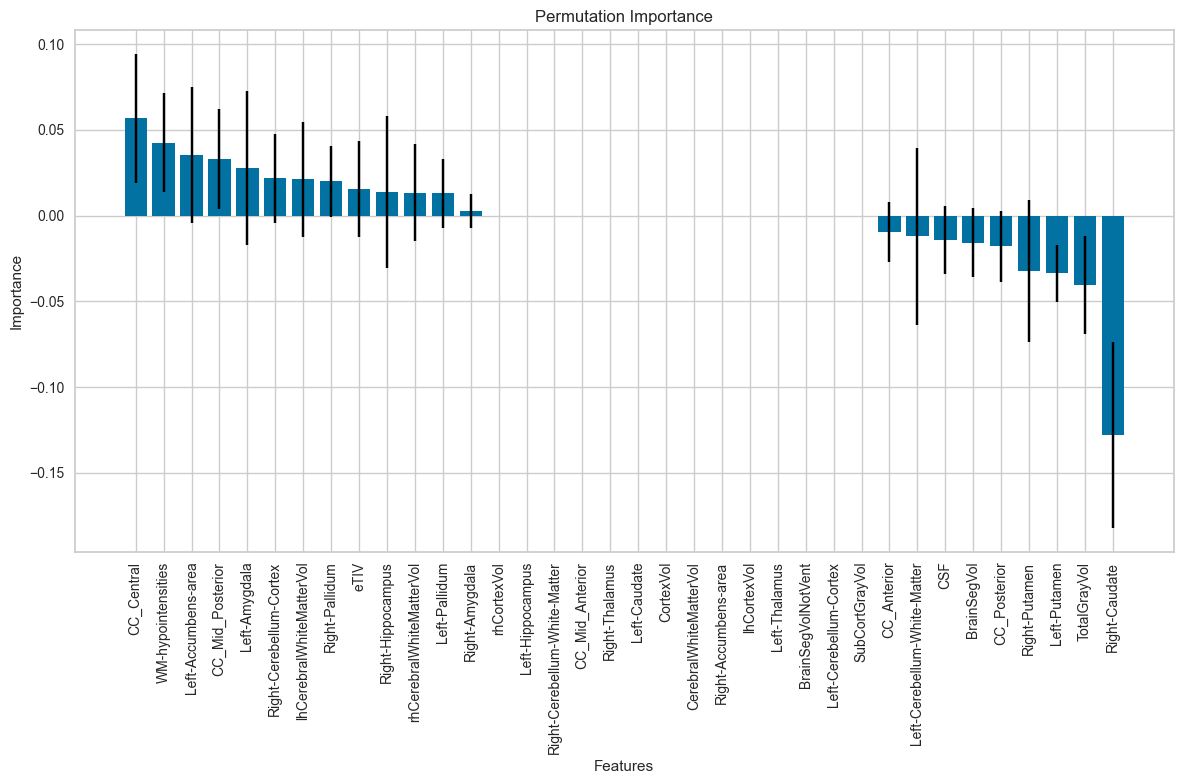


Top 10 most important features:
CC_Central                    : 0.0567 +/- 0.0375
WM-hypointensities            : 0.0425 +/- 0.0289
Left-Accumbens-area           : 0.0354 +/- 0.0397
CC_Mid_Posterior              : 0.0329 +/- 0.0290
Left-Amygdala                 : 0.0279 +/- 0.0449
Right-Cerebellum-Cortex       : 0.0217 +/- 0.0260
lhCerebralWhiteMatterVol      : 0.0213 +/- 0.0336
Right-Pallidum                : 0.0200 +/- 0.0208
eTIV                          : 0.0154 +/- 0.0280
Right-Hippocampus             : 0.0138 +/- 0.0445


In [75]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming r_perm is your permutation importance result
# and X_val is your validation set

r_perm = result

# Results of permutation importance calculation (mean +/- std)
for i in r_perm.importances_mean.argsort()[::-1]:
    print(f"{X_val.columns[i]:<8}"
    f": {r_perm.importances_mean[i]:.3f}"
    f" +/- {r_perm.importances_std[i]:.3f}")

# Plot the results
plt.figure(figsize=(12, 8))
indices = r_perm.importances_mean.argsort()[::-1]
plt.bar(range(X_val.shape[1]), r_perm.importances_mean[indices])
plt.xticks(range(X_val.shape[1]), X_val.columns[indices], rotation=90)
plt.errorbar(range(X_val.shape[1]), r_perm.importances_mean[indices], 
             yerr=r_perm.importances_std[indices], fmt='none', c='black')
plt.title('Permutation Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

# Sort the features based on the mean importance scores
sorted_indices = np.argsort(r_perm.importances_mean)[::-1]
sorted_importances = r_perm.importances_mean[sorted_indices]
sorted_std = r_perm.importances_std[sorted_indices]

# Plot the sorted feature importances
#plt.figure(figsize=(12, 8))
#plt.bar(range(len(sorted_importances)), sorted_importances)
#plt.xticks(range(len(sorted_importances)), [X_val.columns[i] for i in sorted_indices], rotation=90)
#plt.errorbar(range(len(sorted_importances)), sorted_importances, yerr=sorted_std, fmt='none', c='black')
#plt.xlabel('Feature')
#plt.ylabel('Importance')
#plt.title('Sorted Permutation Importance')
#plt.tight_layout()
#plt.show()

# Print top 10 most important features
print("\nTop 10 most important features:")
for i in range(10):
    print(f"{X_val.columns[sorted_indices[i]]:<30}: {sorted_importances[i]:.4f} +/- {sorted_std[i]:.4f}")


Negative permutation importance is an interesting phenomenon that can occur when calculating feature importance using the permutation importance method. 

1. Normal Permutation Importance:
   - Typically, permutation importance is non-negative.
   - It measures how much the model's performance decreases when a feature is randomly shuffled.
   - A higher value indicates a more important feature.

2. Negative Permutation Importance:
   - Occurs when randomly shuffling a feature actually improves the model's performance.
   - This might seem counterintuitive at first.

Reasons for Negative Permutation Importance:

1. Overfitting:
   - If a model has overfit to noise in a particular feature, randomly shuffling that feature might actually improve performance on the validation set.
   - This suggests the model was relying on spurious patterns in that feature.

2. Feature Interactions:
   - In complex models with many feature interactions, shuffling one feature might accidentally create beneficial interactions with other features.

3. Random Chance:
   - With a small number of permutations or a small validation set, you might see negative importance due to random chance.
   - Increasing `n_repeats` can help mitigate this.

4. Data Leakage:
   - If there's some unintended correlation between your features and target in the validation set, shuffling might break this unwanted connection.

5. Model Instability:
   - Some models might be unstable, leading to performance fluctuations even with small data changes.

Interpreting Negative Permutation Importance:

1. Feature Quality:
   - It might indicate that the feature is not useful or even harmful to the model's performance.
   - Consider removing or further investigating such features.

2. Model Evaluation:
   - It can be a sign that your model or feature set needs reevaluation.
   - You might need to consider feature selection, regularization, or model simplification.

3. Data Quality:
   - It could point to data quality issues or unexpected patterns in your dataset.

4. Caution in Interpretation:
   - If you see many negative importances, especially large ones, it's a red flag that something might be wrong with your model or data.

Actions to Take:

1. Increase `n_repeats` to ensure the result is not due to random chance.
2. Cross-validate your results to see if the negative importance is consistent.
3. Investigate the feature and its relationship with other features and the target variable.
4. Consider removing or transforming features with consistent negative importance.
5. Reassess your model's complexity and consider simplifying if overfitting is suspected.

Remember, while negative permutation importance can be informative, it's often a sign that further investigation is needed into your data, features, or model.

### Recursive Feature Elimination, RFE

In [76]:
# Compute RFE
from sklearn.feature_selection import RFE

y_train_num = get_config('y_train').map({'0_HC': 0, '1_IBS': 1})   
y_test_num = get_config('y_test').map({'0_HC': 0, '1_IBS': 1})   

# Assuming best_model is a XGBOOST model
rfe = RFE(estimator=xgb1, n_features_to_select=5)
rfe.fit(get_config('X_train'), y_train_num)

# Print the selected features
print("Selected features:", get_config('X_train').columns[rfe.support_])

Selected features: Index(['Left-Cerebellum-White-Matter', 'Left-Putamen', 'Right-Caudate',
       'Right-Hippocampus', 'WM-hypointensities'],
      dtype='object')


## SHAP values

**SHAP (SHapley Additive exPlanations) values** provide a powerful and unified framework to interpret machine learning model predictions, particularly in terms of feature importance. Developed based on [cooperative game theory](https://en.wikipedia.org/wiki/Cooperative_game_theory), SHAP values offer a way to understand the contribution of each feature to the prediction of a specific instance, making them highly useful in fields like medical AI where interpretability is crucial.


<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png" width="600" />
 

### Fundamentals of SHAP Values

1. **Game Theory Background**: SHAP values are derived from Shapley values in game theory, which are a method to fairly distribute the 'payout' (or contribution) among players (features) in a coalition (model).


2. **Individual Prediction Explanation**: SHAP values explain the prediction of an instance by computing the contribution of each feature to the prediction. Unlike global feature importance, which gives an overall picture, SHAP values provide local interpretability for each prediction.

3. **Additive Feature Attribution**: In SHAP, the model's output is expressed as the sum of the effects of each feature being introduced into a conditional expectation.

### How SHAP Values Work in Practice

- **Model Agnostic**: SHAP can be applied to any machine learning model, be it a simple linear model or a complex deep learning model.

- **Computing SHAP Values**: For a given prediction, SHAP values are calculated by comparing what a model predicts with and without each feature. However, since features can be interdependent, this is done in a way that accounts for all possible combinations of features.

- **Interpretation**: A SHAP value for a feature for a particular prediction represents how much knowing the feature's value moves the prediction away from the mean prediction for the dataset.

### Significance in Medical AI

- **Insight into Model Predictions**: SHAP values can reveal why a model makes certain decisions, which is vital in healthcare settings where understanding the rationale behind a diagnosis or treatment recommendation is as important as the accuracy of the prediction itself.

- **Patient-Specific Explanations**: They can provide personalized insights, like why a particular patient was classified as high risk for a disease.

- **Clinical Research and Decision Making**: Helps in identifying and understanding key factors that drive medical conditions, which can be instrumental in both clinical research and decision-making.

### Example

Imagine a model predicting diabetes risk. The SHAP value for a feature like 'blood sugar level' in a particular patient's prediction tells us how much having that specific blood sugar level, compared to the average level in the training data, impacts the model's risk prediction for that patient.

### Challenges and Considerations

- **Complexity and Computation**: Calculating SHAP values, especially for models with a large number of features or complex interactions, can be computationally intensive.

- **Interpretation Nuances**: While SHAP values offer clarity, interpreting them, especially in the context of complex interactions and correlations between features, requires domain expertise.

In conclusion, SHAP values represent a significant advancement in the field of explainable AI, offering clear, detailed, and theoretically grounded insights into model predictions. This is especially critical in medical AI, where transparent and interpretable AI models are crucial for clinical acceptance and ethical considerations.

Cooperative game theory comes into play in the concept of SHAP (SHapley Additive exPlanations) values through the use of Shapley values, which are a solution concept from cooperative game theory. To understand this, let's first delve into what cooperative game theory is and then see how it relates to SHAP values in machine learning.

### Cooperative Game Theory

1. **Basic Concept**: Cooperative game theory deals with how groups of agents (players) can form coalitions and how the payoff (rewards) from any cooperative effort should be distributed among these agents.

2. **Coalitions and Payoffs**: The key focus is on the formation of groups (coalitions) and how the rewards from collaborative efforts are allocated to the members of the coalition.

3. **Shapley Values**: Developed by Lloyd Shapley, the Shapley value is a method to fairly distribute the total gains (or losses) among the players based on their individual contributions. The idea is to find an equitable distribution of payoffs, considering all possible combinations of coalition formation.

### SHAP Values and Cooperative Game Theory

1. **Model as a Cooperative Game**: In the context of SHAP values, each feature in a machine learning model is considered a 'player' in a game. The 'game' is the task of making a prediction, and the 'payoff' is the prediction itself.

2. **Feature Contributions**: The Shapley value calculates the contribution of each feature (player) to the prediction (payoff) by considering all possible combinations of features. It averages the marginal contributions of a feature across all possible combinations.

3. **Fair Allocation of Importance**: Just like Shapley values in game theory aim to distribute payoffs fairly based on contribution, SHAP values in machine learning aim to distribute the 'credit' or 'blame' of a prediction among the features based on their contribution.

### Practical Example

Imagine a model predicting patient health outcomes based on various features like age, weight, blood pressure, etc. The SHAP value for each feature tells us how much that feature contributes to a particular prediction, considering the interplay with other features. This is akin to determining how much each player (feature) in a game (the model) contributes to the final score (prediction), considering all possible team (feature combination) scenarios.

### Significance

- **Fairness and Equity**: Just as Shapley values in game theory ensure a fair distribution of rewards, SHAP values in machine learning ensure a fair attribution of importance to features.
- **Interpretability and Transparency**: This approach allows for a more nuanced and transparent interpretation of model predictions, which is especially valuable in critical fields like medical AI.

In summary, cooperative game theory, through the concept of Shapley values, provides a foundational framework for SHAP values in machine learning, ensuring a fair and equitable attribution of feature contributions to model predictions. This intersection of game theory and AI highlights the multidisciplinary nature of advancements in AI interpretability.

In [77]:
xgb1

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cpu', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

Figures saved as 'SHAP_summary_plot_IBS_brain_morphometry.png' and 'SHAP_summary_plot_IBS_brain_morphometry.pdf'


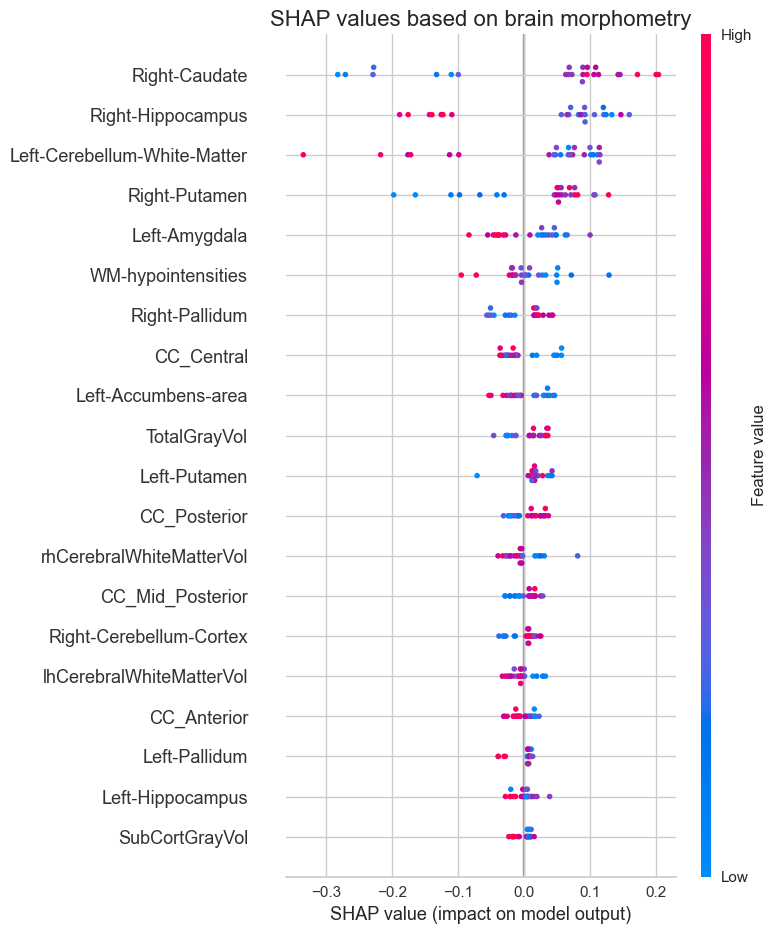

In [78]:
import shap
import matplotlib.pyplot as plt
import os

# Ensure the directory exists
os.makedirs('../figs/', exist_ok=True)

explainer = shap.Explainer(xgb1.predict_proba, get_config('X_train'))
shap_values = explainer(get_config('X_test'))

# When plotting, manually provide feature names
feature_names = get_config('X_test').columns.tolist()

# Function to create and save SHAP summary plot
def create_and_save_shap_plot(file_format):
    plt.figure(figsize=(10, 12))
    shap.summary_plot(shap_values[:,:,1], get_config('X_test'), feature_names=feature_names, show=False)
    plt.title("SHAP values based on brain morphometry", fontsize=16)
    plt.tight_layout()
    plt.savefig(f'../figs/SHAP_summary_plot_IBS_brain_morphometry.{file_format}', dpi=300, bbox_inches='tight')
    
    # Write direct to figs folder on Overleaf
    plt.savefig(f'/Users/arvid/Dropbox/Apps/Overleaf/Evaluation_of_brain_morphometry_and_clinical_data_in_IBS_diagnostics/figs/SHAP_summary_plot_IBS_brain_morphometry.{file_format}', dpi=300, bbox_inches='tight')

    plt.close()

# Create and save the SHAP summary plot as PNG and PDF
create_and_save_shap_plot('png')
create_and_save_shap_plot('pdf')

print("Figures saved as 'SHAP_summary_plot_IBS_brain_morphometry.png' and 'SHAP_summary_plot_IBS_brain_morphometry.pdf'")

# If you want to display the plot in the notebook, create it again
plt.figure(figsize=(10, 12))
shap.summary_plot(shap_values[:,:,1], get_config('X_test'), feature_names=feature_names, show=False)
plt.title("SHAP values based on brain morphometry", fontsize=16)
plt.tight_layout()
plt.show()

In [79]:
shap_values.shape

(24, 36, 2)

This figure is a SHAP (SHapley Additive exPlanations) summary plot, which shows the impact of different features on the model's output. SHAP values help interpret the importance and effect of each feature in a machine learning model's predictions.

Key points about the figure:

1. Features: The y-axis lists various features used in the model, including brain regions (e.g., Right-Hippocampus, Right-Caudate) and cognitive indices (e.g., Verbalskills Index, Recall_Index).

2. SHAP values: The x-axis represents the SHAP value, which indicates the impact on the model output. Positive values (to the right) increase the prediction, while negative values (to the left) decrease it.

3. Feature importance: Features are ordered by importance, with the most impactful at the top (Right-Hippocampus) and least impactful at the bottom (lhCortexVol).

4. Color coding: The color of each point represents the feature value, with red indicating high values and blue indicating low values.

5. Distribution: The spread of points for each feature shows how the impact varies across different samples.

Interpretation:
- Right-Hippocampus has the highest impact, with higher values (red) generally pushing the prediction higher.
- Verbalskills Index is the second most important, with lower values (blue) generally associated with higher predictions.
- Some features, like Right-Caudate, show a more complex relationship, where both high and low values can have significant impacts in different directions.
- Features at the bottom of the list have relatively little impact on the model's predictions.

This plot helps in understanding which features are most influential in the model's decision-making process and how they affect the predictions.

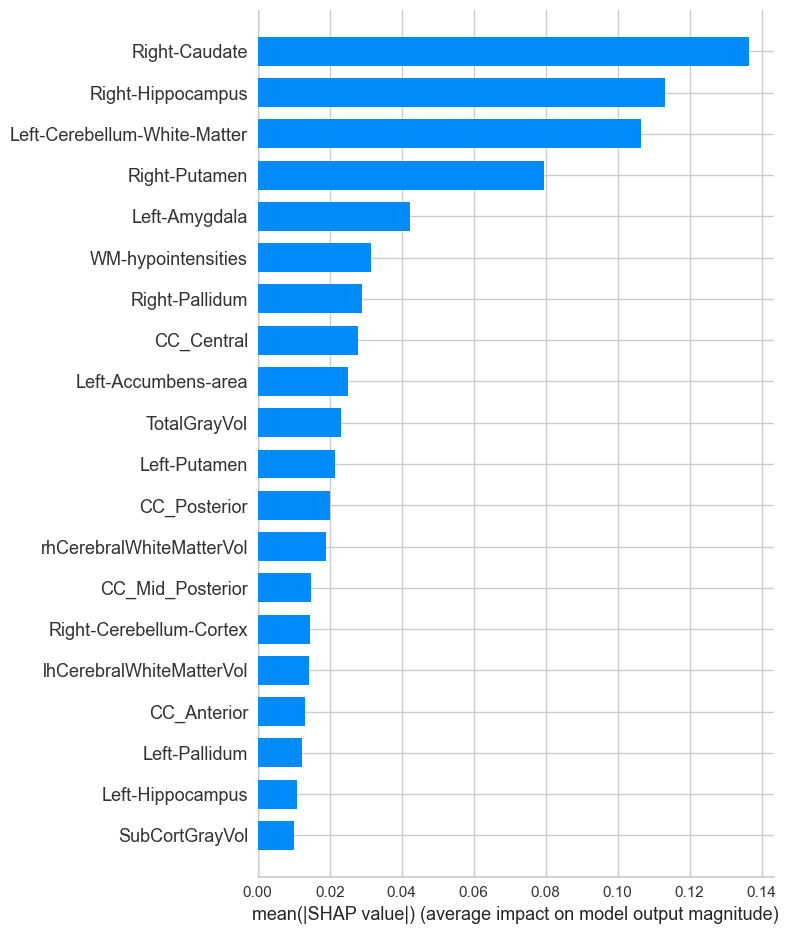

==== COMPUTING SHAP VALUES IN THE TRAINING SET ====


In [80]:
f2, ax = plt.subplots(figsize=(12,8))

f2 = shap.summary_plot(shap_values[:, :, 1], get_config('X_train'), plot_type="bar")   # X_test

print('==== COMPUTING SHAP VALUES IN THE TRAINING SET ====') 

plt.show()

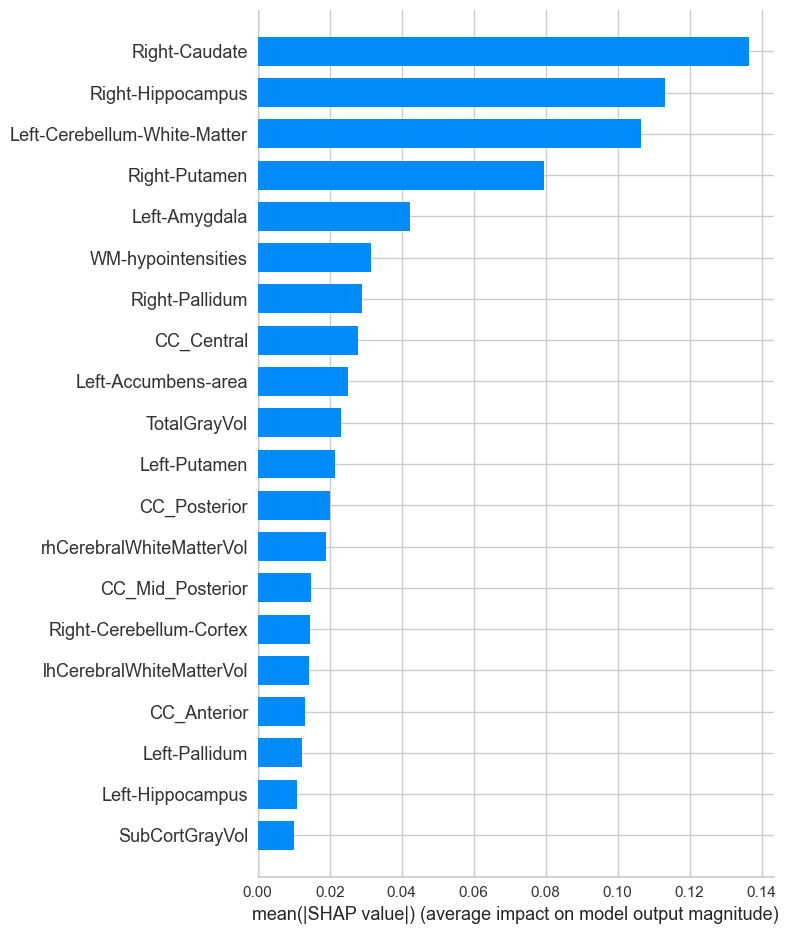

==== COMPUTING SHAP VALUES IN THE TRAINING SET ====


In [81]:
f2, ax = plt.subplots(figsize=(12,8))

f2 = shap.summary_plot(shap_values[:, :, 0], get_config('X_train'), plot_type="bar")   # X_test

print('==== COMPUTING SHAP VALUES IN THE TRAINING SET ====') 

plt.show()

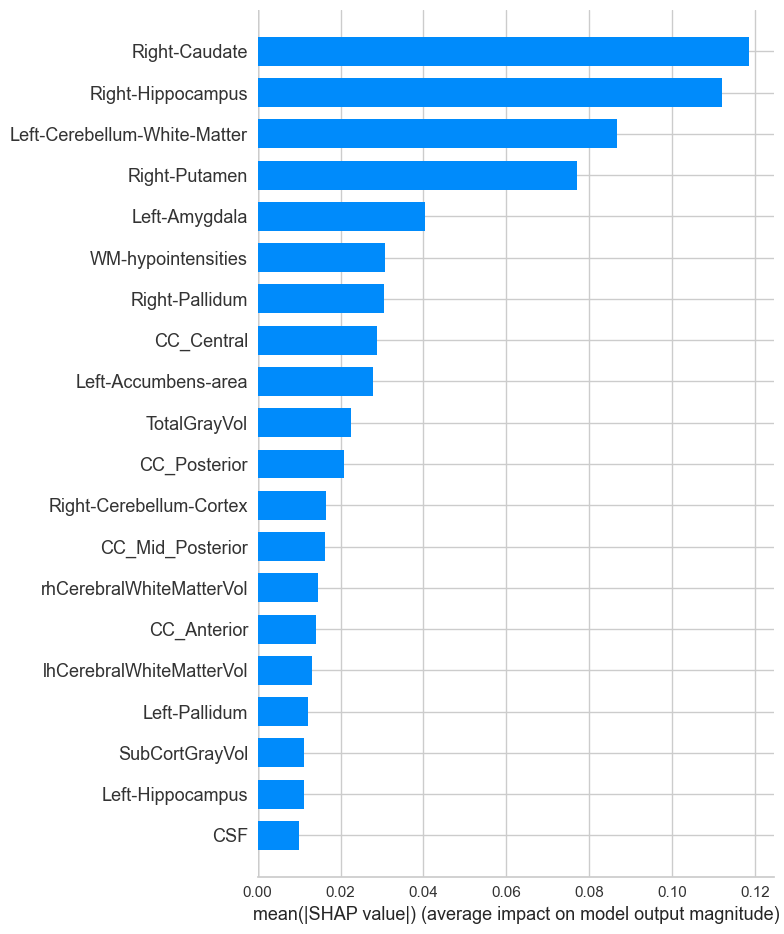

In [82]:
# Assuming best_model is your trained Random Forest model
# and get_config('X_test') returns your test data

# Compute the SHAP values for the test set
explainer = shap.Explainer(xgb1.predict_proba, get_config('X_test'))
shap_values = explainer.shap_values(get_config('X_test'))


# For classification problems, shap_values will be a list of arrays
# (one per class). We need to choose which class to plot.
# Let's assume we want to plot for the IBS class (index 1)

# Plot the SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[:, :, 1], get_config('X_test'), plot_type="bar", show=False)
plt.tight_layout()
plt.show()

In [83]:
?shap_values

Type:        ndarray
String form:
[[[-0.00198513  0.00198513]
           [ 0.08688429 -0.08688429]
           [ 0.00142386 -0.00142386]
           ...
           [ 0.0 <...> 2078]
           ...
           [ 0.00485741 -0.00485741]
           [ 0.01922201 -0.01922201]
           [-0.02857463  0.02857464]]]
Length:      24
File:        ~/opt/anaconda3/envs/ibs-brain/lib/python3.10/site-packages/numpy/__init__.py
Docstring:  
ndarray(shape, dtype=float, buffer=None, offset=0,
        strides=None, order=None)

An array object represents a multidimensional, homogeneous array
of fixed-size items.  An associated data-type object describes the
format of each element in the array (its byte-order, how many bytes it
occupies in memory, whether it is an integer, a floating point number,
or something else, etc.)

Arrays should be constructed using `array`, `zeros` or `empty` (refer
to the See Also section below).  The parameters given here refer to
a low-level method (`ndarray(...)`) for instanti